In [1]:
# Get ELENA
!git clone https://github.com/michelelucente/ELENA.git
%cd ELENA

# Install Python deps for notebooks + examples
# (names follow ELENA’s README; CosmoTransitions is on PyPI)
%pip install -q numpy scipy matplotlib cosmoTransitions NatPy la-forge


Cloning into 'ELENA'...
remote: Enumerating objects: 621, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 621 (delta 166), reused 143 (delta 89), pack-reused 393 (from 1)
Receiving objects: 100% (621/621), 30.17 MiB | 24.28 MiB/s, done.
Resolving deltas: 100% (424/424), done.
/content/ELENA
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.0 MB/s eta 0:00:00


In [2]:
# Add ELENA/src to the Python path for imports (as suggested by the repo)
import sys, os
sys.path.append(os.path.abspath('src'))

In [3]:
%%writefile custom_model.py
"""
custom_model.py

CosmoTransitions-style "fully generic" framework.

You get TWO things in this file:

1) GenericCTModel (framework):
   - A generic_potential subclass where you can plug in ANY tree-level potential
     and ANY particle mass spectrum (bosons + fermions).
   - CosmoTransitions then automatically computes:
       * V1 (CW)
       * V1T (finite-T thermal)
       * Daisy resummation (Parwani or AE/Carrington style)

2) AbelianHiggsCT (example model):
   - Your Abelian Higgs (1 complex scalar + U(1) gauge) implemented in the
     proper CosmoTransitions way:
       * input parameters: vev, lambda_, g, Y
       * computes m0sq automatically: m0sq = -lambda_ * vev^2
       * defines boson_massSq(X,T) and fermion_massSq(X)
       * supports daisyType = 0/1/2 like your earlier model

If you want "any potential", you use GenericCTModel and provide callables:
  V0_fun(X), boson_fun(X,T)->(M2,dof,c), fermion_fun(X)->(M2,dof)

Notes:
- This uses CosmoTransitions built-in Jb/Jf splines (not your high-T expansion).
- DaisyType meanings (CosmoTransitions convention):
    0: no daisies
    1: Parwani (all modes thermal masses in V1T)
    2: Arnold-Espinosa / Carrington (ring only for zero modes)
"""

import numpy as np
from cosmoTransitions import generic_potential, helper_functions
import temperatures as temp
from dof_interpolation import g_rho
from utils import convert_units


# -------------------------------
# 1) Fully-generic CT-style model
# -------------------------------
class GenericCTModel(generic_potential.generic_potential):
    """
    A fully generic CosmoTransitions model.

    You supply:
      - V0_fun(X) -> float/array
      - boson_fun(X, T) -> (M2, dof, c)
      - fermion_fun(X) -> (M2, dof)
    where:
      * M2 has shape (..., n_species)
      * dof is 1D array length n_species
      * c is 1D array length n_species (MS-bar constants; 3/2 scalars/fermions, 5/6 gauge)

    Then Vtot is built using CT's V1 and V1T + optional daisy resummation.
    """

    def init(
        self,
        Ndim,
        V0_fun,
        boson_fun,
        fermion_fun=None,
        Vct_fun=None,
        xstep=1e-3,
        Tstep=1e-2,
        daisyType=2,
        deriv_order=2,
    ):
        self.Ndim = int(Ndim)

        if V0_fun is None or boson_fun is None:
            raise ValueError("GenericCTModel requires at least V0_fun and boson_fun.")

        self._V0_fun = V0_fun
        self._boson_fun = boson_fun
        self._fermion_fun = fermion_fun if fermion_fun is not None else (lambda X: (0.0, 0.0))
        self._Vct_fun = Vct_fun if Vct_fun is not None else (lambda X: 0.0)

        self.x_eps = float(xstep)
        self.T_eps = float(Tstep)
        self.daisyResum = int(daisyType)
        self.deriv_order = int(deriv_order)

    # --- required by CT ---
    def V0(self, X):
        return self._V0_fun(np.asanyarray(X, dtype=float))

    def Vct(self, X):
        return self._Vct_fun(np.asanyarray(X, float))

    def boson_massSq(self, X, T):
        return self._boson_fun(np.asanyarray(X, dtype=float), float(np.asanyarray(T, dtype=float)))

    def fermion_massSq(self, X):
        return self._fermion_fun(np.asanyarray(X, dtype=float))

    def Vtot(self, X, T, include_radiation=True):
        """
        Total effective potential:
          V0 + V1 (CW) + Vct + V1T (+ daisies depending on scheme)

        We use CT's built-in V1 and V1T. Daisy handling:
          - daisyResum=0: no resummation
          - daisyResum=1: Parwani (all modes resummed by using thermal masses in V1T)
          - daisyResum=2: Arnold-Espinosa/Carrington (ring only for zero modes)
        """
        X = np.asanyarray(X, dtype=float)
        T = np.asanyarray(T, dtype=float)

        fermions = self.fermion_massSq(X)

        # V0 + CW + counterterms
        bosons0 = self.boson_massSq(X, 0.0 * T)
        y = self.V0(X) + self.V1(bosons0, fermions) + self.Vct(X)

        # Thermal part + daisies
        if self.daisyResum == 0:
            y += self.V1T(bosons0, fermions, T, include_radiation)
        elif self.daisyResum == 1:
            # Parwani: use thermal masses everywhere in V1T
            bosonsT = self.boson_massSq(X, T)
            y += self.V1T(bosonsT, fermions, T, include_radiation)
        elif self.daisyResum == 2:
            # Arnold-Espinosa/Carrington: add ring (zero modes only)
            bosonsT = self.boson_massSq(X, T)
            m20, nb, c  = bosons0
            m2T, nbT, cT = bosonsT
            # ring: -T/(12π) Σ nb * [ (m2T)^(3/2) - (m20)^(3/2) ]
            Vdaisy = np.real(-(T / (12.0 * np.pi)) * np.sum(nb * (np.power(m2T + 0j, 1.5) - np.power(m20 + 0j, 1.5)), axis=-1))
            y += self.V1T(bosons0, fermions, T, include_radiation) + Vdaisy
        else:
            raise ValueError("daisyType must be 0, 1, or 2 for GenericCTModel.")

        return y

    def DVtot(self, X, T):
        """
        Normalized: V(X,T) - V(0,T)
        """
        X = np.asanyarray(X, dtype=float)
        return self.Vtot(X, T, include_radiation=False) - self.Vtot(X * 0.0, T, include_radiation=False)

    def gradV(self, X, T):
        """
        Finite-difference gradient dV/dX.
        """
        try:
            f = self._gradV
        except AttributeError:
            self._gradV = helper_functions.gradientFunction(
                self.Vtot, self.x_eps, self.Ndim, self.deriv_order
            )
            f = self._gradV

        T = np.asanyarray(T)[..., np.newaxis, np.newaxis]
        return f(X, T, False)


# -------------------------------------------
# 2) Example: Abelian Higgs in CT-style form
# -------------------------------------------
class AbelianHiggsCT(generic_potential.generic_potential):
    """
    Abelian Higgs: 1 complex scalar (H + G) and a U(1) gauge boson.
    Order parameter: φ (1D).

    Tree-level:
      V0 = 1/2 m0^2 φ^2 + 1/4 λ φ^4
      with m0^2 = -λ vev^2 (so φ=vev is the T=0 minimum)

    Daisies are handled by CT with:
      daisyType 0/1/2
    where you implement thermal masses inside boson_massSq(X,T) for daisyType 1/2.
    """

    def init(self, vev=500.0, lambda_=2.4e-3, g=0.54, Y=1.0,
             xstep=5e-5, Tstep=5e-5, daisyType=2, deriv_order=2):
        self.Ndim = 1

        self.vev = float(vev)
        self.lam = float(lambda_)
        self.g = float(g)
        self.Y = float(Y)

        # m0^2 from (vev, lambda)
        self.m0sq = -self.lam * (self.vev ** 2)

        self.x_eps = float(xstep)
        self.T_eps = float(Tstep)
        self.daisyResum = int(daisyType)
        self.deriv_order = int(deriv_order)

    def V0(self, X):
        X = np.asanyarray(X, dtype=float)
        phi = X[..., 0]
        return 0.5 * self.m0sq * phi * phi + 0.25 * self.lam * (phi ** 4)

    def _Pi_scalar(self, T):
        # LO thermal mass for scalar (one complex scalar)
        # Π_s ≈ (λ/3 + g^2 Y^2/4) T^2
        T = float(T)
        return (self.lam / 3.0 + (self.g * self.g * self.Y * self.Y) / 4.0) * T * T

    def _mD2(self, T):
        # Debye mass for U(1) with one complex scalar: m_D^2 ≈ (g^2 Y^2/3) T^2
        T = float(T)
        return (self.g * self.g * self.Y * self.Y / 3.0) * T * T

    def boson_massSq(self, X, T):
        """
        Returns (M2, dof, c) with species ordering:
          [H, G, A_T, A_L]
        dof: [1, 1, 2, 1]
        c:   [3/2, 3/2, 5/6, 5/6]
        """
        X = np.asanyarray(X, dtype=float)
        phi = X[..., 0]
        T = float(np.asanyarray(T, dtype=float))

        # tree-level masses
        mH2 = self.m0sq + 3.0 * self.lam * phi * phi
        mG2 = self.m0sq + 1.0 * self.lam * phi * phi
        mA2 = (self.g * self.Y) ** 2 * phi * phi

        if self.daisyResum in (1, 2) and T > 0.0:
            Pi_s = self._Pi_scalar(T)
            mD2 = self._mD2(T)
            # Parwani/AE: implement thermal masses for the modes you want resummed
            mH2_eff = mH2 + Pi_s
            mG2_eff = mG2 + Pi_s
            mAT2_eff = mA2               # transverse typically not Debye-screened
            mAL2_eff = mA2 + mD2
        else:
            mH2_eff, mG2_eff = mH2, mG2
            mAT2_eff, mAL2_eff = mA2, mA2

        M2 = np.stack([mH2_eff, mG2_eff, mAT2_eff, mAL2_eff], axis=-1)
        dof = np.array([1.0, 1.0, 2.0, 1.0])
        c   = np.array([3.0/2.0, 3.0/2.0, 5.0/6.0, 5.0/6.0])
        return M2, dof, c

    def fermion_massSq(self, X):
        # no fermions in this model
        return 0.0, 0.0

    def Vct(self, X):
        # no counterterms by default
        return 0.0

    def approxZeroTMin(self):
        return [np.array([self.vev], dtype=float)]

    def DVtot(self, X, T):
        return self.Vtot(X, T, False) - self.Vtot(np.asanyarray(X, dtype=float) * 0.0, T, False)

    def gradV(self, X, T):
        try:
            f = self._gradV
        except AttributeError:
            self._gradV = helper_functions.gradientFunction(
                self.Vtot, self.x_eps, self.Ndim, self.deriv_order
            )
            f = self._gradV
        T = np.asanyarray(T)[..., np.newaxis, np.newaxis]
        return f(X, T, False)

    # --- New methods for derivatives with respect to Temperature ---
    def dVdT_unnormalized(self, X, T, include_radiation=True, units='GeV'):
        """
        Calculates dV/dT using finite differences of Vtot.
        """
        X = np.asanyarray(X, dtype=float)
        T = float(T)
        step = self.T_eps

        Tm = max(T - step, 0.0)
        Tp = T + step

        V_minus = self.Vtot(X, Tm, include_radiation=include_radiation)
        V_plus = self.Vtot(X, Tp, include_radiation=include_radiation)

        if Tm == T: # Handle T near zero
            val = (V_plus - self.Vtot(X, T, include_radiation=include_radiation)) / step
        else:
            val = (V_plus - V_minus) / (Tp - Tm)
        return val

    def dVdT(self, X, T, include_radiation=True, include_SM=True, units='GeV'):
        """
        Calculates dV/dT including the s_SM term.
        """
        val_unnorm = self.dVdT_unnormalized(X, T, include_radiation=include_radiation, units=units)
        if include_SM:
            try:
                s_SM_val = temp.s_SM(T, units=units)
            except TypeError:
                s_SM_val = temp.s_SM(T)
            return val_unnorm - s_SM_val
        return val_unnorm

    def d2VdT2(self, X, T, include_radiation=True, include_SM=True, units='GeV'):
        """
        Calculates d^2V/dT^2 using finite differences of Vtot.
        """
        X = np.asanyarray(X, dtype=float)
        T = float(T)
        step = self.T_eps

        Tm = max(T - step, 0.0)
        Tp = T + step

        V_minus = self.Vtot(X, Tm, include_radiation=include_radiation)
        V_current = self.Vtot(X, T, include_radiation=include_radiation)
        V_plus = self.Vtot(X, Tp, include_radiation=include_radiation)

        if Tm == T: # Handle T near zero, use forward difference
            Tpp = T + 2*step
            V_plus2 = self.Vtot(X, Tpp, include_radiation=include_radiation)
            val = (V_plus2 - 2 * V_plus + V_current) / (step**2)
        else:
            val = (V_plus - 2 * V_current + V_minus) / (step**2)

        return val


# -------------------------------
# Quick usage examples (comments)
# -------------------------------
"""
# Example A: Use AbelianHiggsCT directly
from custom_model import AbelianHiggsCT
m = AbelianHiggsCT(vev=500.0, lambda_=1.65e-3, g=0.54, daisyType=2)
vT = m.findMinimum(X=m.approxZeroTMin(), T=120.0)
DV = m.DVtot([100.0], 150.0)

# Example B: Use GenericCTModel for ANY potential/mass spectrum
from custom_model import GenericCTModel
def V0_fun(X):
    phi = np.asanyarray(X)[...,0]
    lam = 1e-3; v = 500.0
    m0sq = -lam*v*v
    return 0.5*m0sq*phi*phi + 0.25*lam*phi**4

def boson_fun(X,T):
    # ...return (M2,dof,c)...
    pass

gmodel = GenericCTModel(Ndim=1, V0_fun=V0_fun, boson_fun=boson_fun, daisyType=2)
"""


Writing custom_model.py


In [5]:
import numpy as np
import sys
import importlib

# Ensure custom_model is reloaded if it was previously imported
if 'custom_model' in sys.modules:
    importlib.reload(sys.modules['custom_model'])

from utils import convert_units
from custom_model import AbelianHiggsCT  # instead of CustomModel

# You can still choose units randomly if you like
units = np.random.choice(list(convert_units.keys()))

# Parameters
lambda_ = 6e-3
g       = 0.749938
vev, units = 3, "GeV"
description = "BP4"

# Construct "model"
dp = AbelianHiggsCT(
    vev=vev,
    lambda_=lambda_,
    g=g,
    daisyType=2,              # 0/1/2
    xstep=vev*1e-3,
    Tstep=vev*1e-3
)

# Potential difference relative to phi=0:
V  = lambda phi, T: dp.DVtot(np.atleast_1d(phi).reshape(-1, 1), T)

# Gradient (dV/dphi):
dV = lambda phi, T: dp.gradV(np.atleast_1d(phi).reshape(-1, 1), T)[..., 0]

print(f"lambda = {lambda_}")
print(f"g      = {g}")
print(f"vev    = {vev} {units}")


phi_test = 10.0
T_test   = 200.0
print("V(10, 150) =", V(phi_test, T_test))
print("dV(10, 150) =", dV(phi_test, T_test))

lambda = 0.006
g      = 0.749938
vev    = 3 GeV
V(10, 150) = [242683.25242126]
dV(10, 150) = [48043.621521]


In [6]:
from temperatures import find_T_min, find_T_max, refine_Tmin

T_max, vevs_max, max_min_vals, false_min_tmax = find_T_max(V, dV, precision= 1e-2, Phimax = 15*vev, step_phi = vev * 1e-2, tmax=2.5 * vev)
T_min, vevs_min, false_min_tmin = find_T_min(V, dV, tmax=T_max, precision = 1e-2, Phimax = 10*vev, step_phi = vev * 1e-2, max_min_vals = max_min_vals)

if T_max is not None and T_min is not None:
    maxvev = np.max(np.concatenate((vevs_max, vevs_min)))
elif T_max is not None:
    maxvev = np.max(vevs_max)
elif T_min is not None:
    maxvev = np.max(vevs_min)
else:
    maxvev = None

T_min = refine_Tmin(T_min, V, dV, maxvev, log_10_precision = 6) if T_min is not None else None

print(f"T_max = {T_max:.6e} {units}")
print(f"T_min = {T_min:.6e} {units}")

T_max = 3.594000e+01 GeV
T_min = 7.188000e-01 GeV


In [7]:
T_max, vevs_max, max_min_vals, false_min_tmax

(np.float64(35.93999999999909),
 array([957.11548574, 957.11547501, 957.11546418]),
 [44.993663636953535, 957.1154641803473],
 [0, 0])

In [8]:
T_min, vevs_min, false_min_tmin

(np.float64(0.7187999999999818), array([957.12172141]), [0, 0])

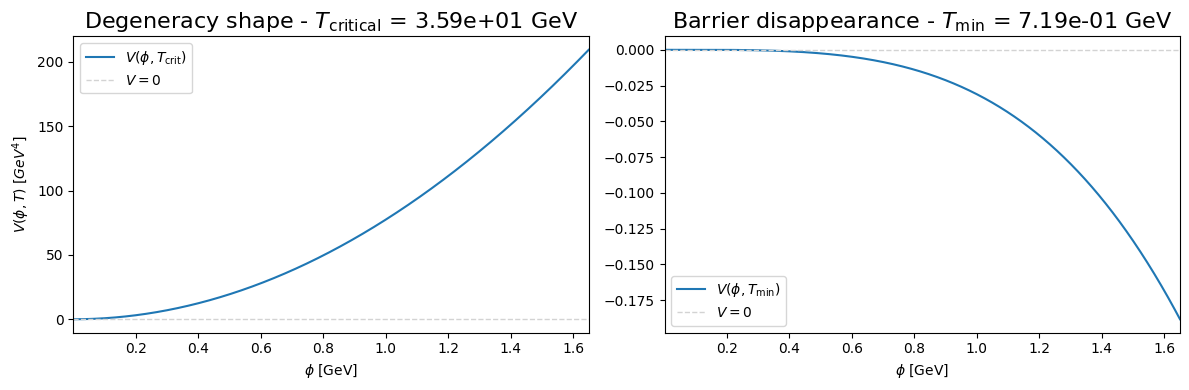

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# The `phi` variable was used in V() and for plot limits but was not defined in this scope.
# It should be defined with the same parameters used for T_max and T_min calculations.

_Phimax_for_plot = 0.55* vev # vev is 500.0 from earlier cell
_T_step_for_calc = 1e-4 # T_step is 1e-2 from earlier cell
_step_phi_for_plot = vev * _T_step_for_calc # This will be 500 * 0.01 = 5.0

# Create the phi array
phi = np.arange(_step_phi_for_plot, _Phimax_for_plot + _step_phi_for_plot, _step_phi_for_plot)


if T_max is not None:
    v_max = V(phi, T_max)
if T_min is not None:
    v_min = V(phi, T_min)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

if T_max is not None:
    v_max = V(phi, T_max)
    # Changed label and title strings to raw strings (r"...") to avoid SyntaxWarning
    axes[0].plot(phi, v_max, label = r'$V(\phi, T_\mathrm{{crit}})$')
    axes[0].set_title(rf'Degeneracy shape - $T_\mathrm{{critical}}$ = {T_max:.2e} {units}',fontsize=16)
    axes[0].set_xlim(phi[0], phi[-1])
    # Changed ylabel string to raw string to avoid SyntaxWarning with \phi
    axes[0].set_ylabel(rf'$V(\phi, T)$ $[{units}^{4}]$')

if T_min is not None:
    v_min = V(phi, T_min)
    # Changed label and title strings to raw strings (r"...") to avoid SyntaxWarning
    axes[1].plot(phi, v_min, label= r'$V(\phi, T_\mathrm{{min}})$')
    axes[1].set_title(rf'Barrier disappearance - $T_\mathrm{{min}}$ = {T_min:.2e} {units}',fontsize=16)
    axes[1].set_xlim(phi[0], phi[-1])

for ax in axes:
    # Changed xlabel string to raw string to avoid SyntaxWarning with \phi
    ax.set_xlabel(rf'$\phi$ [{units}]')
    ax.axhline(false_min_tmax[1], color='lightgrey', linestyle='--', linewidth=1, label = "$V = 0$")
    ax.legend()

plt.tight_layout()
plt.show()

In [10]:
maxvev

np.float64(957.1217214139557)

In [11]:
import numpy as np
from espinosa import Vt_vec

def V_1d(phi, T):
    out = V(phi, T)
    a = np.asarray(out, dtype=float)
    return float(a) if a.ndim == 0 else a.reshape(-1)

def dV_1d(phi, T):
    out = dV(phi, T)
    a = np.asarray(out, dtype=float)
    return float(a) if a.ndim == 0 else a.reshape(-1)

true_vev = {}
false_vev = {}
S3overT = {}
V_min_value = {}
phi0_min = {}
V_exit = {}

def action_over_T(T, c_step_phi=1e-3, precision=1e-3):
    instance = Vt_vec(
        T, V_1d, dV_1d,
        step_phi=c_step_phi,
        precision=precision,
        vev0=maxvev,
        ratio_vev_step0=50
    )
    if instance.barrier:
        true_vev[T] = instance.true_min
        false_vev[T] = instance.phi_original_false_vev
        S3overT[T] = instance.action_over_T
        V_min_value[T] = instance.min_V
        phi0_min[T] = instance.phi0_min
        V_exit[T] = instance.V_exit


        return instance.action_over_T
    return None



In [12]:
import time
import numpy as np

# Extend the temperature range by a factor
T_range_extension_factor = 0.5
T_min_extended = T_min - (T_max - T_min) * T_range_extension_factor
T_max_extended = T_max + (T_max - T_min) * T_range_extension_factor

# Define the extended temperature range
n_points = 100
temperatures = np.linspace(T_min_extended, T_max_extended, n_points)

# Vectorize the action calculation for each temperature
action_vec = np.vectorize(action_over_T)

# Measure the computation time for the action values
start_time = time.time()
action_vec(temperatures)
end_time = time.time()
print(f"Elapsed time: {end_time - start_time:.2f} seconds")

# Sort temperatures and store them for future use
temperatures = np.array(sorted(S3overT.keys()))


Elapsed time: 2.93 seconds


In [13]:
T_min_extended

np.float64(-16.891799999999574)

<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:24: SyntaxWarning: invalid escape sequence '\p'
<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\ '
<>:34: SyntaxWarning: invalid escape sequence '\p'
<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\ '
<>:39: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:24: SyntaxWarning: invalid escape sequence '\p'
<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:33: SyntaxWarning: invalid escape sequence '\m'
<>:33: SyntaxWarning: invalid escape sequence '\ '
<>:34: SyntaxWarning: invalid escape sequence '\p'
<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\ '
<>:39: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-4058944208.py:19: SyntaxWarning: invalid escape sequence '\p'
 

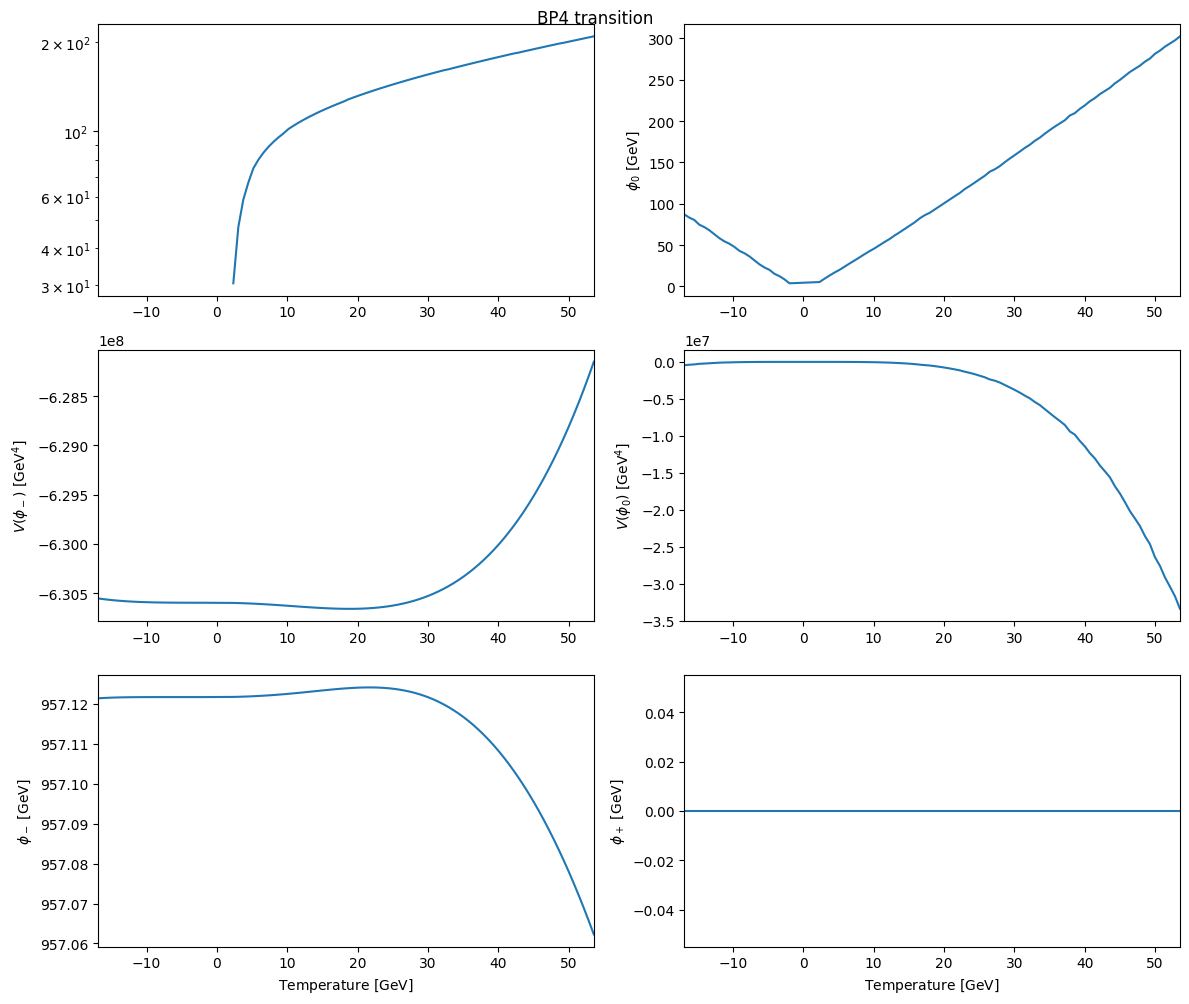

Minimum of the action at T = 2.32e+00 GeV


In [14]:
import matplotlib.pyplot as plt
from pathlib import Path

# Define the directory to save figures
figure_dir = "figures/"
Path(figure_dir).mkdir(parents=True, exist_ok=True)

fig, axes = plt.subplots(3, 2, figsize=(12, 10))

axes[0, 0].plot(temperatures, [S3overT[T] for T in temperatures])
#axes[0, 0].set_title('') # Corrected: removed stray ')
#axes[0, 0].set_xlabel(f"T [{units}]")
axes[0, 0].set_ylabel('') # Corrected: removed stray ')
axes[0, 0].set_yscale('log')

axes[0, 1].plot(temperatures, [phi0_min[T] for T in temperatures])
#axes[0, 1].set_title('') # Corrected: removed stray ')
#axes[0, 1].set_xlabel(f"T [{units}]")
axes[0, 1].set_ylabel(f"$\phi_0\ \mathrm{{[{units}]}}$")

axes[1, 0].plot(temperatures, [V_min_value[T] for T in temperatures])
#axes[1, 0].set_title('V(true_vev)')
#axes[1, 0].set_xlabel(f"T [{units}]")
axes[1, 0].set_ylabel(f"$V(\phi_-)\ \mathrm{{[{units}^4]}}$")

axes[1, 1].plot(temperatures, [V_exit[T] for T in temperatures])
#axes[1, 1].set_title('') # Corrected: removed stray ')
#axes[1, 1].set_xlabel(f"T [{units}]")
axes[1, 1].set_ylabel(f"$V(\phi_0)\ \mathrm{{[{units}^4]}}$")

axes[2, 0].plot(temperatures, [true_vev[T] for T in temperatures])
#axes[2, 0].set_title('True vev')
axes[2, 0].set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
axes[2, 0].set_ylabel(f"$\phi_-\ \mathrm{{[{units}]}}$")

axes[2, 1].plot(temperatures, [false_vev[T] for T in temperatures])
#axes[2, 1].set_title('False vev')
axes[2, 1].set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
axes[2, 1].set_ylabel(f"$\phi_+\ \mathrm{{[{units}]}}$")

for ax in axes.flatten():
    ax.set_xlim(temperatures[0], temperatures[-1])

plt.tight_layout()
fig.suptitle(f'{description} transition', y=1.00)
plt.savefig(figure_dir + f"action_{description}.pdf", dpi=300, bbox_inches='tight')
plt.show()

print(f"Minimum of the action at T = {temperatures[np.argmin([S3overT[T] for T in temperatures])]:.2e} {units}")

In [15]:
import importlib, inspect
import numpy as np
import temperatures as temp

# 1) reset the module (undo previous monkey patches)
temp = importlib.reload(temp)

# 2) patch s_SM so it accepts `units=` (only if the real one doesn't)
_sig = inspect.signature(temp.s_SM)
if "units" not in _sig.parameters:
    _real_s_SM = temp.s_SM
    def s_SM(T, units=None):
        return _real_s_SM(T)
    temp.s_SM = s_SM

def _asfloat(x):
    return float(np.asarray(x, dtype=float).squeeze())

# 3) safe compute_logP_f (forces scalars/1D everywhere)
def compute_logP_f_safe(m, V_min_value, S3overT, v_w, units='GeV', cum_method='cumulative_simpson'):
    # choose cumulative integrator
    if cum_method == 'cumulative_simpson' and hasattr(temp, "cumulative_simpson"):
        cum_f = temp.cumulative_simpson
    else:
        from scipy.integrate import cumulative_trapezoid
        cum_f = cumulative_trapezoid

    # Fix: Use m.DVtot instead of m.Vtot
    V = m.DVtot

    Temps = np.array(sorted(set(V_min_value.keys()) & set(S3overT.keys())), dtype=float)
    if Temps.size < 2:
        return np.array([]), Temps, np.array([]), np.array([]), np.array([])

    steps = len(Temps)
    T_step = max((Temps[-1] - Temps[0]) * 1e-3, 1e-6)

    def finite_dVdT(phi, T, step=T_step):
        Tm = max(T - step, 0.0)
        Tp = T + step
        if Tm == T:
            val = (V(np.array([phi]), Tp) - V(np.array([phi]), T)) / step
        else:
            val = (V(np.array([phi]), Tp) - V(np.array([phi]), Tm)) / (Tp - Tm)
        return _asfloat(val) - temp.s_SM(T, units=units)

    def finite_d2VdT2(phi, T):
        step2 = 0.5 * T_step
        Tm = max(T - step2, 0.0)
        Tp = T + step2
        if Tm == T:
            Tpp = T + 2 * step2
            f0 = finite_dVdT(phi, T,  step2)
            f1 = finite_dVdT(phi, Tp, step2)
            f2 = finite_dVdT(phi, Tpp, step2)
            return (f2 - 2*f1 + f0) / (step2**2)
        f_plus  = finite_dVdT(phi, Tp, step2)
        f_minus = finite_dVdT(phi, Tm, step2)
        return (f_plus - f_minus) / (Tp - Tm)

    e_vacuum = np.array([-_asfloat(V_min_value[t]) for t in Temps], dtype=float)
    e_radiation = np.pi**2 * temp.g_rho(Temps / temp.convert_units[units]) * Temps**4 / 30.0
    H = np.sqrt((e_vacuum + e_radiation) / 3.0) / (temp.M_pl * temp.convert_units[units])

    S3_T = np.array([_asfloat(S3overT[t]) for t in Temps], dtype=float)
    Gamma = Temps**4 * (S3_T / (2*np.pi))**(3/2) * np.exp(-S3_T)

    ratio_V = np.array([finite_d2VdT2(0.0, T) / finite_dVdT(0.0, T) for T in Temps], dtype=float)

    logP_f = np.zeros_like(Temps, dtype=float)
    f_ext = ratio_V * Gamma / H

    # integrate
    for i in range(steps - 1):
        cum_ratio_V = cum_f(ratio_V[i:], x=Temps[i:], initial=0.0)

        f1 = ratio_V[i:] / H[i:] * np.exp(cum_ratio_V / 3.0)
        cum_f1 = cum_f(f1, x=Temps[i:], initial=0.0)

        f2 = f_ext[i:] * np.exp(-cum_ratio_V) * (cum_f1**3)
        cum_f2 = cum_f(f2, x=Temps[i:], initial=0.0)

        logP_f[i] = - (4.0/243.0) * np.pi * (v_w**3) * cum_f2[-1]

    return logP_f, Temps, ratio_V, Gamma, H

temp.compute_logP_f = compute_logP_f_safe



In [16]:
import numpy as np
from scipy.integrate import cumulative_trapezoid

import temperatures as temp
from dof_interpolation import g_rho
from utils import convert_units

def _crossing_linear(x, y, ystar):
    """
    Return x where y crosses ystar (linear interp). Assumes x increasing.
    Picks the first crossing from high-T side (largest x) going down in T if needed.
    """
    x = np.asarray(x, float)
    y = np.asarray(y, float)

    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if x.size < 2:
        return np.nan

    # find any sign change in (y-ystar)
    s = y - ystar
    idx = np.where(s[:-1] * s[1:] <= 0)[0]
    if idx.size == 0:
        return np.nan

    i = idx[0]
    x0, x1 = x[i], x[i+1]
    y0, y1 = y[i], y[i+1]
    if y1 == y0:
        return 0.5*(x0 + x1)
    return x0 + (ystar - y0) * (x1 - x0) / (y1 - y0)

def compute_logP_f_fixed(V_min_value, S3overT, *, v_w=1.0, units="MeV",
                         use_g_running=True, clip_exp=700.0):
    # Use only temps that exist in BOTH dicts
    Temps = np.array(sorted(set(V_min_value.keys()) & set(S3overT.keys())), dtype=float)
    if Temps.size < 3:
        raise RuntimeError("Need >=3 temperatures with both V_min_value and S3overT.")

    # Vacuum + radiation energy density -> H(T)
    e_vac = np.array([-V_min_value[T] for T in Temps], dtype=float)
    g = np.asarray(g_rho(Temps / convert_units[units]), dtype=float)
    e_rad = (np.pi**2 / 30.0) * g * Temps**4
    H = np.sqrt(np.maximum(e_vac + e_rad, 0.0) / 3.0) / (temp.M_pl * convert_units[units])

    # Nucleation rate prefactor
    S3_T = np.array([S3overT[T] for T in Temps], dtype=float)
    S3_clip = np.clip(S3_T, 0.0, clip_exp)  # stabilise exp(-S3/T)
    Gamma = Temps**4 * (np.maximum(S3_T, 0.0) / (2*np.pi))**1.5 * np.exp(-S3_clip)

    # ---- KEY FIX: ratio_V for radiation era (because your V dropped the constant T^4 term)
    if use_g_running:
        ln_g = np.log(np.maximum(g, 1e-300))
        dln_g_dT = np.gradient(ln_g, Temps)
        ratio_V = 3.0/Temps + dln_g_dT
    else:
        ratio_V = 3.0/Temps

    # Same structure as ELENA compute_logP_f
    logP_f = np.zeros_like(Temps)
    f_ext = ratio_V * Gamma / np.maximum(H, 1e-300)

    for i in range(len(Temps) - 1):
        Ts = Temps[i:]
        r  = ratio_V[i:]
        Hs = H[i:]
        fE = f_ext[i:]

        cum_r = cumulative_trapezoid(r, x=Ts, initial=0.0)

        f1 = r/np.maximum(Hs, 1e-300) * np.exp(cum_r/3.0)
        cum_f1 = cumulative_trapezoid(f1, x=Ts, initial=0.0)

        f2 = fE * np.exp(-cum_r) * cum_f1**3
        cum_f2 = cumulative_trapezoid(f2, x=Ts, initial=0.0)

        logP_f[i] = -(4.0/243.0) * np.pi * (v_w**3) * cum_f2[-1]

    return logP_f, Temps, ratio_V, Gamma, H

# ----------------------------
# RUN + milestones
# ----------------------------
logP_f, Temps, ratio_V, Gamma, H = compute_logP_f_fixed(
    V_min_value, S3overT, v_w=1.0, units=units, use_g_running=True
)

P_f = np.exp(np.clip(logP_f, -700.0, 0.0))  # physical volume fraction (0..1)
nH  = temp.N_bubblesH(Temps, Gamma, logP_f, H, ratio_V)

print(f"Temps range: {Temps[0]} → {Temps[-1]}   N={len(Temps)}")
print(f"ratio_V range: {np.nanmin(ratio_V)} → {np.nanmax(ratio_V)}")
print(f"logP_f range: {np.nanmin(logP_f)} → {np.nanmax(logP_f)}")
print(f"P_f range: {np.nanmin(P_f)} → {np.nanmax(P_f)}")
print(f"nH range: {np.nanmin(nH)} → {np.nanmax(nH)}")

T_nuc = _crossing_linear(Temps, nH, 1.0)
T_perc = _crossing_linear(Temps, P_f, 0.71)
T_completion = _crossing_linear(Temps, P_f, 0.01)

print(f"\nT_nuc = {T_nuc} {units}")
print(f"T_perc = {T_perc} {units}")
print(f"T_completion = {T_completion} {units}")

if np.isnan(T_nuc):
    print("Note: No nucleation found in this window (max(nH) < 1). Try extending the T scan.")
if np.isnan(T_perc):
    print("Note: P_f never reached 0.71 in this window.")
if np.isnan(T_completion):
    print("Note: P_f never reached 0.01 in this window.")


Temps range: -16.891799999999574 → 53.55059999999864   N=95
ratio_V range: -1.4340986986466195 → 1.4182035665338264
logP_f range: -6.259382887570152e+37 → 0.0
P_f range: 9.85967654375977e-305 → 1.0
nH range: -0.0 → 22427.86491689384

T_nuc = 26.103739583101724 GeV
T_perc = 22.011480222835466 GeV
T_completion = 20.82475878238344 GeV


/tmp/ipython-input-2523059889.py:75: RuntimeWarning: invalid value encountered in multiply
  f2 = fE * np.exp(-cum_r) * cum_f1**3


In [17]:
T_min

np.float64(0.7187999999999818)

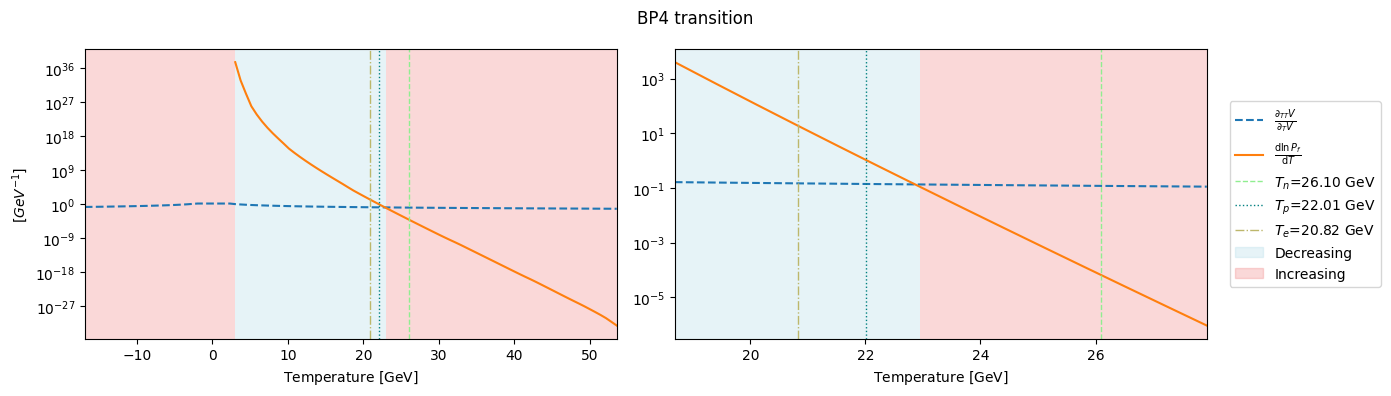

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ---- required inputs assumed to exist ----
# Temps, ratio_V, logP_f, T_nuc, T_perc, T_completion, units

# optional labels/paths
description = globals().get("description", "3D DR")
figure_dir  = globals().get("figure_dir", "")

# ---- derivatives for plotting ----
d_dT_logP_f = np.gradient(logP_f, Temps)

# ---- plotting-safe versions (log-scale cannot show <=0) ----
floor = 1e-300
ratio_plot = np.clip(np.abs(ratio_V), floor, None)
dlogP_plot = np.clip(np.abs(d_dT_logP_f), floor, None)

# ---- zoom mask around milestones (for right panel) ----
t_mil_min = np.nanmin([T_completion, T_perc, T_nuc])
t_mil_max = np.nanmax([T_completion, T_perc, T_nuc])

i0 = max(int(np.argmin(np.abs(Temps - t_mil_min))) - 3, 0)
i1 = min(int(np.argmin(np.abs(Temps - t_mil_max))) + 3, len(Temps)-1)
mask = np.zeros_like(Temps, dtype=bool)
mask[i0:i1+1] = True

# ---- figure ----
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# left: full range
axes[0].plot(Temps, ratio_plot, label=r"$\frac{\partial_{TT}V}{\partial_T V}$", linestyle="--")
axes[0].plot(Temps, dlogP_plot, label=r"$$\frac{\mathrm{d}\ln P_f}{\mathrm{d}T}$")
axes[0].set_xlim(Temps[0], Temps[-1])
axes[0].set_ylabel(rf"$[{units}^{{-1}}]$")

# right: zoomed range
axes[1].plot(Temps[mask], ratio_plot[mask], label=r"$\frac{\partial_{TT}V}{\partial_T V}$", linestyle="--")
axes[1].plot(Temps[mask], dlogP_plot[mask], label=r"$\frac{\mathrm{d}\ln P_f}{\mathrm{d}T}$")
axes[1].set_xlim(Temps[mask][0], Temps[mask][-1])

# legend patches for shading
decreasing_patch = mpatches.Patch(color="lightblue",  alpha=0.3, label="Decreasing")
increasing_patch = mpatches.Patch(color="lightcoral", alpha=0.3, label="Increasing")

for ax in axes:
    ax.set_yscale("log")
    ax.set_xlabel(rf"$\mathrm{{Temperature\ [{units}]}}$")

    ax.axvline(T_nuc,        color="lightgreen", linestyle="--", linewidth=1, label=rf"$T_n$={T_nuc:.2f} {units}")
    ax.axvline(T_perc,       color="teal",       linestyle=":",  linewidth=1, label=rf"$T_p$={T_perc:.2f} {units}")
    ax.axvline(T_completion, color="darkkhaki",  linestyle="-.", linewidth=1, label=rf"$T_e$={T_completion:.2f} {units}")

    # shading (use the SAME abs-comparison you’re plotting)
    for i in range(len(Temps) - 1):
        if dlogP_plot[i] >= ratio_plot[i]:
            ax.axvspan(Temps[i], Temps[i+1], facecolor="lightblue", alpha=0.3)
        else:
            ax.axvspan(Temps[i], Temps[i+1], facecolor="lightcoral", alpha=0.3)

# put a clean legend outside on the right
handles, labels = axes[1].get_legend_handles_labels()
handles += [decreasing_patch, increasing_patch]
labels  += [decreasing_patch.get_label(), increasing_patch.get_label()]
axes[1].legend(handles=handles, labels=labels, loc="center left", bbox_to_anchor=(1.03, 0.5))

fig.suptitle(f"{description} transition", y=0.98)
plt.tight_layout()
plt.savefig(figure_dir + f"volume_{description}.pdf", dpi=300, bbox_inches="tight")
plt.show()


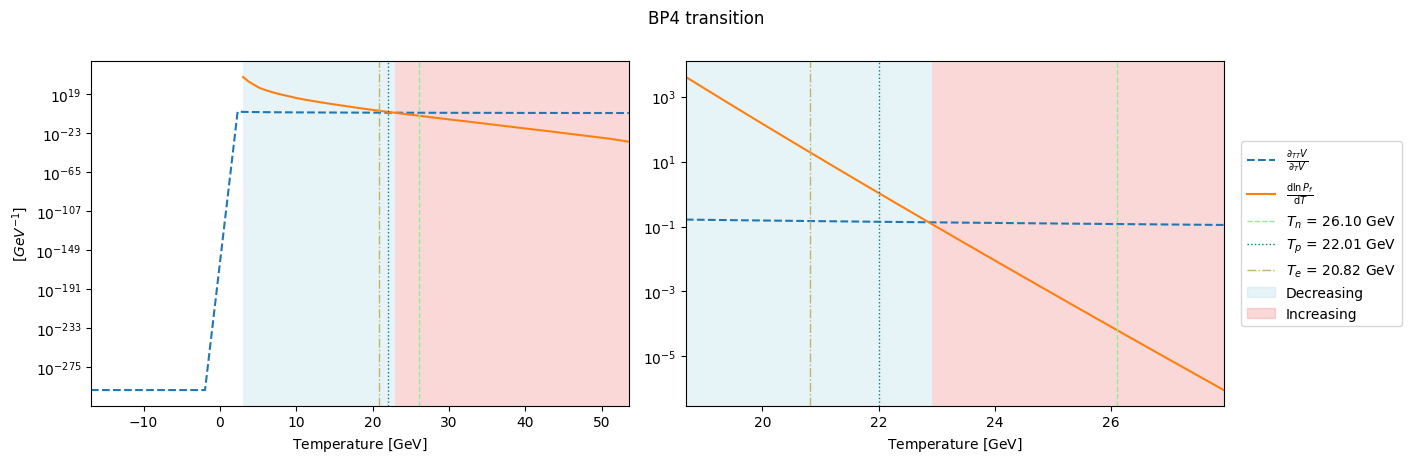

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

# assumes you already have:
# Temps, ratio_V, logP_f, T_nuc, T_perc, T_completion, units, description, figure_dir
# and (optionally) mask

# ---------- derive d/dT log(P_f) ----------
d_dT_logP_f = np.gradient(logP_f, Temps)

# ---------- log-scale safe arrays (plotting only) ----------
ratio_plot = np.clip(np.asarray(ratio_V, float), 1e-300, None)
dlog_plot  = np.clip(np.asarray(d_dT_logP_f, float), 1e-300, None)

# ---------- define zoom mask if not present / too small ----------
if "mask" not in globals() or np.sum(mask) < 3:
    t_lo = np.nanmin([T_completion, T_perc, T_nuc])
    t_hi = np.nanmax([T_completion, T_perc, T_nuc])
    mask = (Temps >= t_lo) & (Temps <= t_hi)
    if np.sum(mask) < 3:
        mask = np.ones_like(Temps, dtype=bool)

# ---------- intersections between (d/dT logP_f) and (ratio_V) ----------
diff = np.asarray(d_dT_logP_f, float) - np.asarray(ratio_V, float)
finite = np.isfinite(Temps) & np.isfinite(diff)
T_f = Temps[finite]
d_f = diff[finite]

intersections = []
for i in range(len(T_f) - 1):
    y1, y2 = d_f[i], d_f[i + 1]
    if y1 == 0.0:
        intersections.append(float(T_f[i]))
    if y1 * y2 < 0.0:
        x1, x2 = T_f[i], T_f[i + 1]
        # linear root of y(x)=0
        intersections.append(float(x1 - y1 * (x2 - x1) / (y2 - y1)))

# points for precise shading
all_points = np.unique(np.clip(np.concatenate([Temps, intersections]), Temps.min(), Temps.max()))
all_points.sort()

# ---------- plot ----------
os.makedirs(figure_dir, exist_ok=True)
fig, axes = plt.subplots(1, 2, figsize=(14, 4), constrained_layout=True)

# full panel
axes[0].plot(Temps, ratio_plot, label=r"$V_{TT}/V_T$", linestyle="--")
axes[0].plot(Temps, dlog_plot,  label=r"$\mathrm{d}\ln P_f/\mathrm{d}T$")
axes[0].set_xlim(Temps[0], Temps[-1])
axes[0].set_ylabel(rf"$[{units}^{{-1}}]$")

# zoom panel
axes[1].plot(Temps[mask], ratio_plot[mask], label=r"$\frac{\partial_{TT}V}{\partial_T V}$", linestyle="--")
axes[1].plot(Temps[mask], dlog_plot[mask],  label=r"$\frac{\mathrm{d}\ln P_f}{\mathrm{d}T}$")
axes[1].set_xlim(Temps[mask][0], Temps[mask][-1])

# legend patches
decreasing_patch = mpatches.Patch(color="lightblue",  alpha=0.3, label="Decreasing")
increasing_patch = mpatches.Patch(color="lightcoral", alpha=0.3, label="Increasing")

for ax in axes:
    ax.set_yscale("log")
    ax.set_xlabel(rf"$\mathrm{{Temperature\ [{units}]}}$")

    # milestone lines (keep labels only once per axis)
    ax.axvline(T_nuc,        color="lightgreen", linestyle="--", linewidth=1, label=rf"$T_n$ = {T_nuc:.2f} {units}")
    ax.axvline(T_perc,       color="teal",       linestyle=":",  linewidth=1, label=rf"$T_p$ = {T_perc:.2f} {units}")
    ax.axvline(T_completion, color="darkkhaki",  linestyle="-.", linewidth=1, label=rf"$T_e$ = {T_completion:.2f} {units}")

    # background shading with intersection-refined bins
    for i in range(len(all_points) - 1):
        a, b = all_points[i], all_points[i + 1]
        mid = 0.5 * (a + b)
        d_mid = np.interp(mid, Temps, d_dT_logP_f)
        r_mid = np.interp(mid, Temps, ratio_V)

        if np.isfinite(d_mid) and np.isfinite(r_mid):
            if d_mid >= r_mid:
                ax.axvspan(a, b, facecolor="lightblue",  alpha=0.3)
            else:
                ax.axvspan(a, b, facecolor="lightcoral", alpha=0.3)

# put legend outside on the right panel
handles, labels = axes[1].get_legend_handles_labels()
handles += [decreasing_patch, increasing_patch]
labels  += ["Decreasing", "Increasing"]
axes[1].legend(handles, labels, loc="center left", bbox_to_anchor=(1.02, 0.5))

fig.suptitle(f"{description} transition", y=1.12)
plt.savefig(os.path.join(figure_dir, f"volume_{description}.pdf"), dpi=300, bbox_inches="tight")
plt.show()


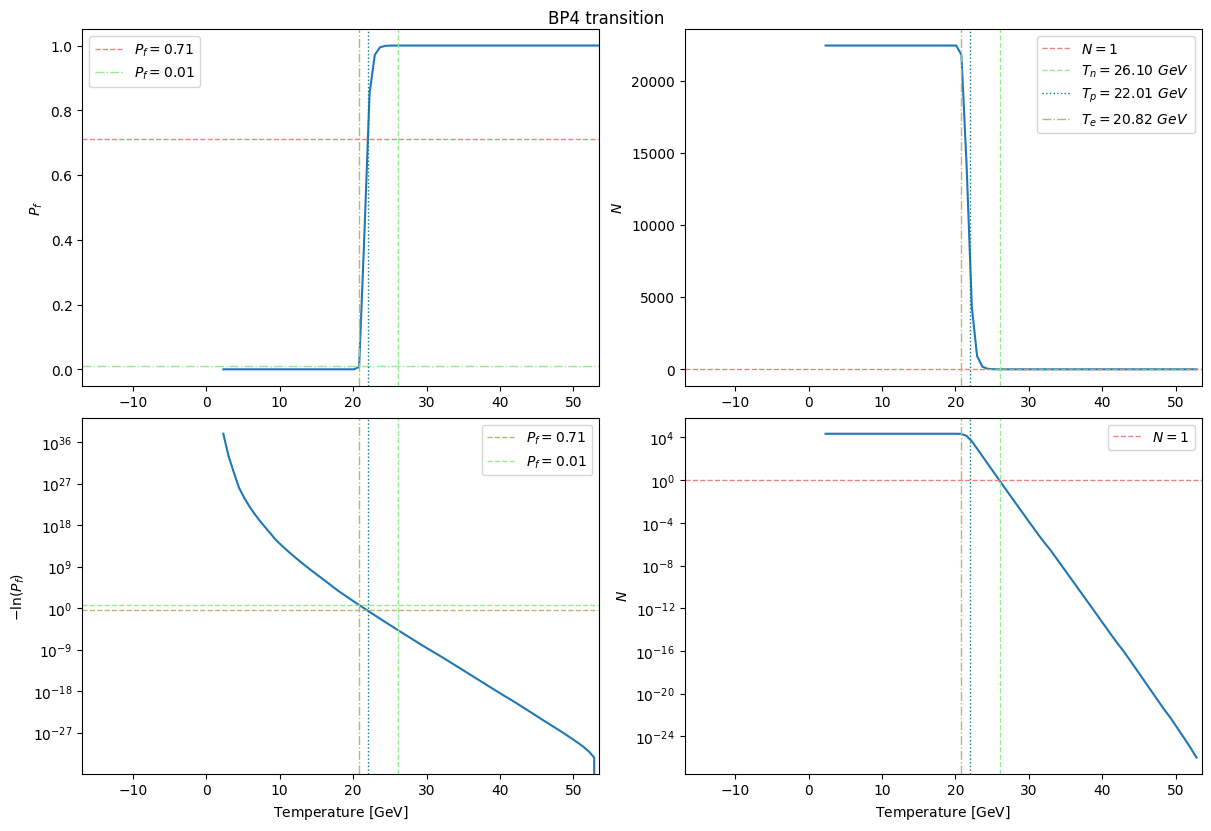

Average number of bubbles at lowest valid T, N = 2.243e+04


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import os

# assumes you already have:
# Temps, logP_f, nH, T_nuc, T_perc, T_completion, units, description, figure_dir

os.makedirs(figure_dir, exist_ok=True)

# plotting-safe Pf (avoid underflow to 0 for the first panel if you want)
Pf = np.exp(np.clip(logP_f, -700.0, 0.0))

mask_nH = np.isfinite(nH) & (nH > 0)

fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

# --- Pf linear ---
axes[0,0].plot(Temps, Pf)
axes[0,0].set_ylabel(r"$P_f$")
axes[0,0].axhline(0.71, color="lightcoral", linestyle="--", linewidth=1, label=r"$P_f=0.71$")
axes[0,0].axhline(0.01, color="lightgreen", linestyle="-.", linewidth=1, label=r"$P_f=0.01$")
axes[0,0].legend()

# --- N linear ---
axes[0,1].plot(Temps[mask_nH], nH[mask_nH])
axes[0,1].axhline(1, color="lightcoral", linestyle="--", linewidth=1, label=r"$N=1$")
axes[0,1].set_ylabel(r"$N$")
axes[0,1].legend()

# --- -log Pf (log y) ---
axes[1,0].plot(Temps, -logP_f)
axes[1,0].axhline(-np.log(0.71), color="darkkhaki", linestyle="--", linewidth=1, label=r"$P_f=0.71$")
axes[1,0].axhline(-np.log(0.01), color="lightgreen", linestyle="--", linewidth=1, label=r"$P_f=0.01$")
axes[1,0].set_xlabel(rf"$\mathrm{{Temperature\ [{units}]}}$")
axes[1,0].set_ylabel(r"$-\ln(P_f)$")
axes[1,0].set_yscale("log")
axes[1,0].legend()

# --- N (log y) ---
axes[1,1].plot(Temps[mask_nH], nH[mask_nH])
axes[1,1].axhline(1, color="lightcoral", linestyle="--", linewidth=1, label=r"$N=1$")
axes[1,1].set_xlabel(rf"$\mathrm{{Temperature\ [{units}]}}$")
axes[1,1].set_ylabel(r"$N$")
axes[1,1].set_yscale("log")
axes[1,1].legend()

# --- milestones: add lines without duplicating legend entries ---
for ax in axes.flatten():
    ax.axvline(T_nuc,        color="lightgreen", linestyle="--", linewidth=1)
    ax.axvline(T_perc,       color="teal",       linestyle=":",  linewidth=1)
    ax.axvline(T_completion, color="darkkhaki",  linestyle="-.", linewidth=1)
    ax.set_xlim(Temps[0], Temps[-1])

# add a single milestone legend on the top-right panel (cleaner)
milestone_handles = [
    plt.Line2D([0],[0], color="lightgreen", linestyle="--", linewidth=1, label=rf"$T_n={T_nuc:.2f}\ {units}$"),
    plt.Line2D([0],[0], color="teal",       linestyle=":",  linewidth=1, label=rf"$T_p={T_perc:.2f}\ {units}$"),
    plt.Line2D([0],[0], color="darkkhaki",  linestyle="-.", linewidth=1, label=rf"$T_e={T_completion:.2f}\ {units}$"),
]
axes[0,1].legend(handles=axes[0,1].get_legend_handles_labels()[0] + milestone_handles,
                 labels=axes[0,1].get_legend_handles_labels()[1] + [h.get_label() for h in milestone_handles],
                 loc="best")

fig.suptitle(f"{description} transition", y=1.02)
plt.savefig(os.path.join(figure_dir, f"evolution_{description}.pdf"), dpi=300, bbox_inches="tight")
plt.show()

if np.any(mask_nH):
    print(f"Average number of bubbles at lowest valid T, N = {nH[mask_nH][0]:.3e}")
else:
    print("No valid nH>0 points to report.")


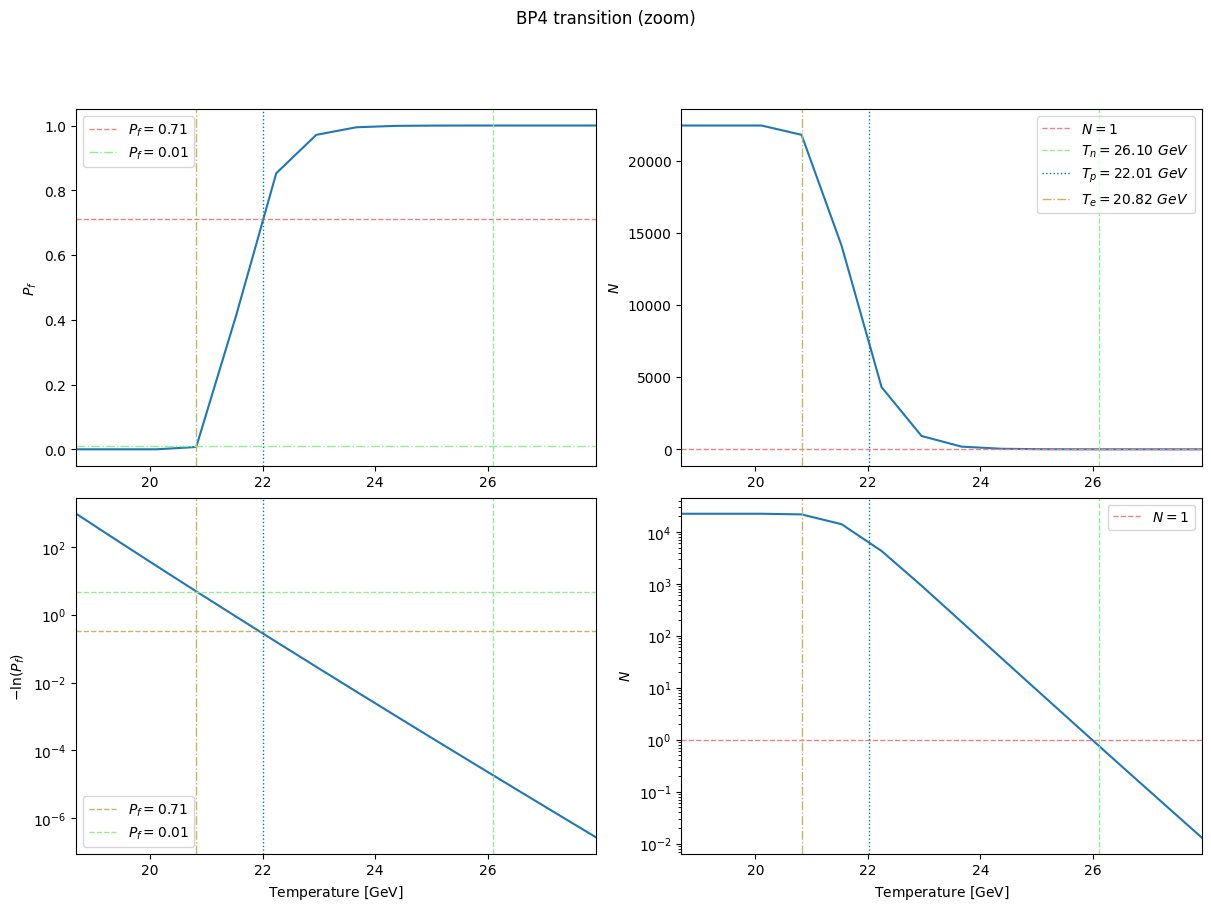

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import os

# assumes you already have:
# Temps, logP_f, nH, mask, T_nuc, T_perc, T_completion, units, description, figure_dir

os.makedirs(figure_dir, exist_ok=True)

# zoom arrays
Tz = Temps[mask]
logPz = logP_f[mask]
nHz = nH[mask]

# plotting-safe Pf
Pfz = np.exp(np.clip(logPz, -700.0, 0.0))

# for log-plot of N: keep only positive finite values
mask_nH_pos = np.isfinite(nHz) & (nHz > 0)

fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

# Pf (linear)
axes[0,0].plot(Tz, Pfz)
axes[0,0].set_ylabel(r"$P_f$")
axes[0,0].axhline(0.71, color="lightcoral", linestyle="--", linewidth=1, label=r"$P_f=0.71$")
axes[0,0].axhline(0.01, color="lightgreen", linestyle="-.", linewidth=1, label=r"$P_f=0.01$")
axes[0,0].legend()

# N (linear)
axes[0,1].plot(Tz, nHz)
axes[0,1].axhline(1, color="lightcoral", linestyle="--", linewidth=1, label=r"$N=1$")
axes[0,1].set_ylabel(r"$N$")
axes[0,1].legend()

# -log Pf (log y)
axes[1,0].plot(Tz, -logPz)
axes[1,0].axhline(-np.log(0.71), color="darkkhaki", linestyle="--", linewidth=1, label=r"$P_f=0.71$")
axes[1,0].axhline(-np.log(0.01), color="lightgreen", linestyle="--", linewidth=1, label=r"$P_f=0.01$")
axes[1,0].set_xlabel(rf"$\mathrm{{Temperature\ [{units}]}}$")
axes[1,0].set_ylabel(r"$-\ln(P_f)$")
axes[1,0].set_yscale("log")
axes[1,0].legend()

# N (log y) – use positive points only
axes[1,1].plot(Tz[mask_nH_pos], nHz[mask_nH_pos])
axes[1,1].axhline(1, color="lightcoral", linestyle="--", linewidth=1, label=r"$N=1$")
axes[1,1].set_xlabel(rf"$\mathrm{{Temperature\ [{units}]}}$")
axes[1,1].set_ylabel(r"$N$")
axes[1,1].set_yscale("log")
axes[1,1].legend()

# milestone vertical lines (avoid duplicating legend spam)
for ax in axes.flatten():
    ax.axvline(T_nuc,        color="lightgreen", linestyle="--", linewidth=1)
    ax.axvline(T_perc,       color="teal",       linestyle=":",  linewidth=1)
    ax.axvline(T_completion, color="darkkhaki",  linestyle="-.", linewidth=1)
    ax.set_xlim(Tz[0], Tz[-1])

# add one milestone legend (clean) in top-right panel
milestone_handles = [
    plt.Line2D([0],[0], color="lightgreen", linestyle="--", linewidth=1, label=rf"$T_n={T_nuc:.2f}\ {units}$"),
    plt.Line2D([0],[0], color="teal",       linestyle=":",  linewidth=1, label=rf"$T_p={T_perc:.2f}\ {units}$"),
    plt.Line2D([0],[0], color="darkkhaki",  linestyle="-.", linewidth=1, label=rf"$T_e={T_completion:.2f}\ {units}$"),
]
h0, l0 = axes[0,1].get_legend_handles_labels()
axes[0,1].legend(h0 + milestone_handles, l0 + [h.get_label() for h in milestone_handles], loc="best")

fig.suptitle(f"{description} transition (zoom)", y=1.12)
plt.savefig(os.path.join(figure_dir, f"evolution_{description}_zoom.pdf"), dpi=300, bbox_inches="tight")
plt.show()


/tmp/ipython-input-3915825340.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[i] = d[T]


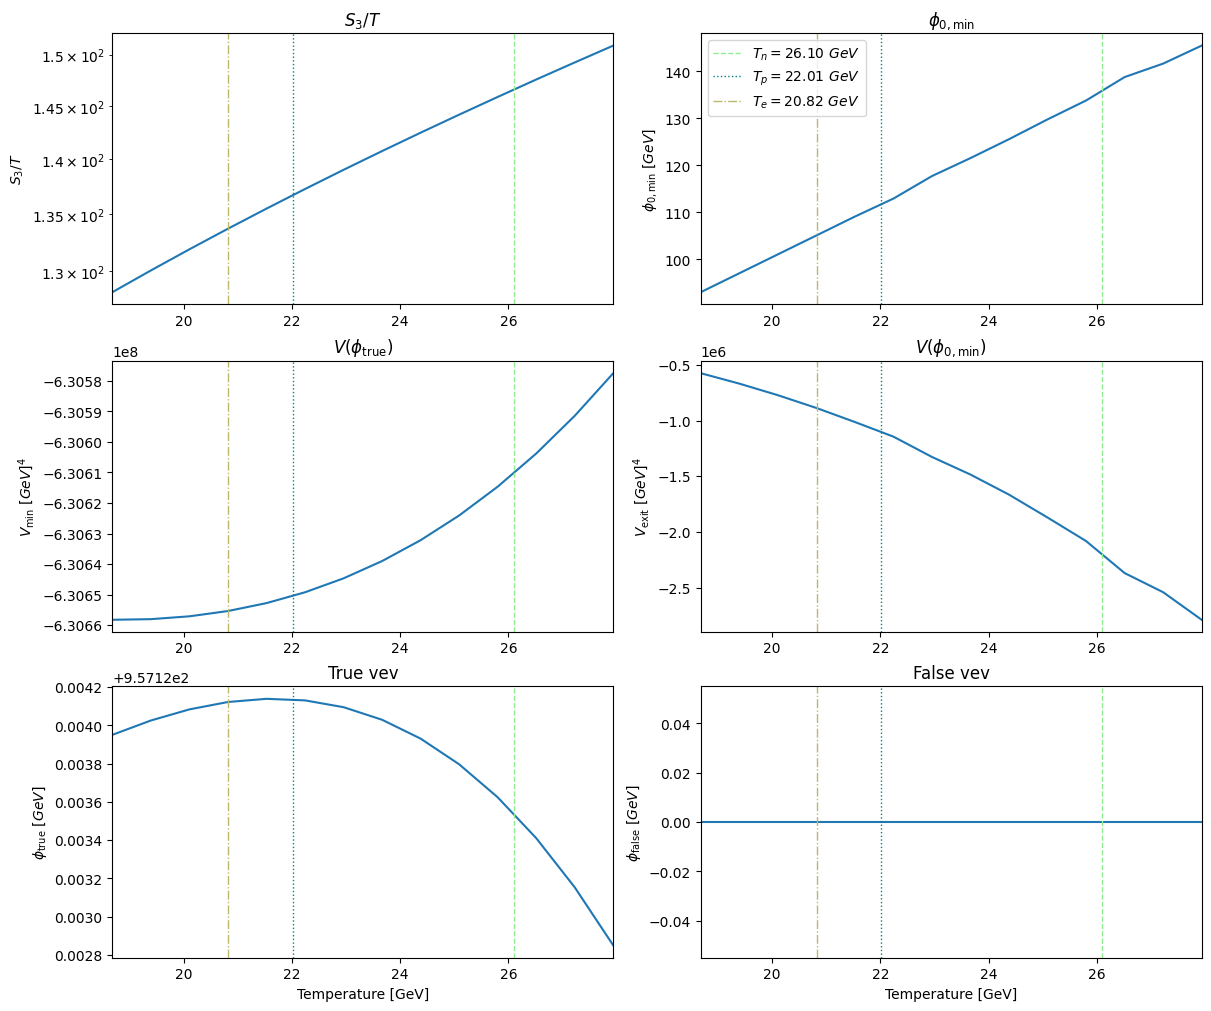

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# assumes you already have:
# Temps, mask, units, T_nuc, T_perc, T_completion
# dicts: S3overT, phi0_min, V_min_value, V_exit, true_vev, false_vev

Tz = np.asarray(Temps[mask], float)

def vec_from_dict(d, Tgrid):
    out = np.full_like(Tgrid, np.nan, dtype=float)
    for i, T in enumerate(Tgrid):
        # keys are floats; try exact then nearest fallback
        if T in d:
            out[i] = d[T]
        else:
            # nearest key fallback (safe for float rounding issues)
            ks = np.asarray(list(d.keys()), float)
            j = int(np.argmin(np.abs(ks - T)))
            out[i] = d[float(ks[j])]
    return out

S3z   = vec_from_dict(S3overT,    Tz)
phi0z = vec_from_dict(phi0_min,   Tz)
Vminz = vec_from_dict(V_min_value,Tz)
Vexz  = vec_from_dict(V_exit,     Tz)
phit  = vec_from_dict(true_vev,   Tz)
phif  = vec_from_dict(false_vev,  Tz)

fig, axes = plt.subplots(3, 2, figsize=(12, 10), constrained_layout=True)

axes[0,0].plot(Tz, np.clip(S3z, 1e-300, None))
axes[0,0].set_title(r"$S_3/T$")
axes[0,0].set_ylabel(r"$S_3/T$")
axes[0,0].set_yscale("log")

axes[0,1].plot(Tz, phi0z)
axes[0,1].set_title(r"$\phi_{0,\mathrm{min}}$")
axes[0,1].set_ylabel(rf"$\phi_{{0,\mathrm{{min}}}}\ [{units}]$")

axes[1,0].plot(Tz, Vminz)
axes[1,0].set_title(r"$V(\phi_{\rm true})$")
axes[1,0].set_ylabel(rf"$V_{{\mathrm{{min}}}}\ [{units}]^4$")

axes[1,1].plot(Tz, Vexz)
axes[1,1].set_title(r"$V(\phi_{0,\mathrm{min}})$")
axes[1,1].set_ylabel(rf"$V_{{\mathrm{{exit}}}}\ [{units}]^4$")

axes[2,0].plot(Tz, phit)
axes[2,0].set_title("True vev")
axes[2,0].set_xlabel(rf"Temperature [{units}]")
axes[2,0].set_ylabel(rf"$\phi_{{\mathrm{{true}}}}\ [{units}]$")

axes[2,1].plot(Tz, phif)
axes[2,1].set_title("False vev")
axes[2,1].set_xlabel(rf"Temperature [{units}]")
axes[2,1].set_ylabel(rf"$\phi_{{\mathrm{{false}}}}\ [{units}]$")

# milestone handles (single clean legend style)
milestone_handles = [
    plt.Line2D([0],[0], color="lightgreen", linestyle="--", linewidth=1, label=rf"$T_n={T_nuc:.2f}\ {units}$"),
    plt.Line2D([0],[0], color="teal",       linestyle=":",  linewidth=1, label=rf"$T_p={T_perc:.2f}\ {units}$"),
    plt.Line2D([0],[0], color="darkkhaki",  linestyle="-.", linewidth=1, label=rf"$T_e={T_completion:.2f}\ {units}$"),
]

for ax in axes.flatten():
    ax.axvline(T_nuc,        color="lightgreen", linestyle="--", linewidth=1)
    ax.axvline(T_perc,       color="teal",       linestyle=":",  linewidth=1)
    ax.axvline(T_completion, color="darkkhaki",  linestyle="-.", linewidth=1)
    ax.set_xlim(Tz[0], Tz[-1])

# put the milestone legend once (top-right panel)
axes[0,1].legend(handles=milestone_handles, loc="best")

plt.show()


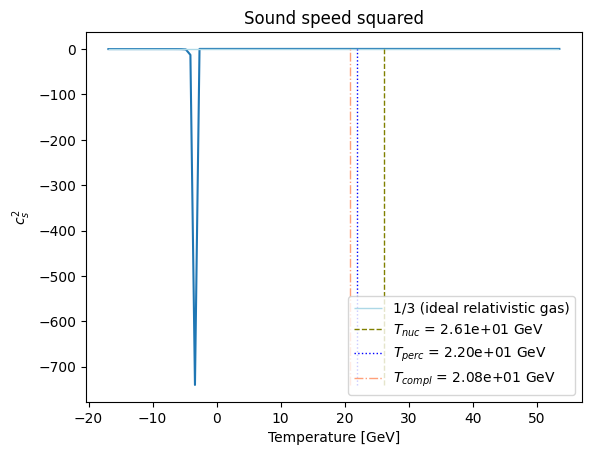

In [23]:
from GWparams import cs2 # Keep this for original if needed, but we will redefine
import numpy as np
import matplotlib.pyplot as plt

# Redefine cs2 locally to handle the input format
def cs2_fixed(T, m, true_vev_dict, units='GeV'):
    # Ensure the field value from true_vev_dict is a 1D array
    phi_val = np.array([true_vev_dict[T]])

    dVdT_val = m.dVdT(phi_val, T, include_radiation=True, include_SM=True, units=units)
    d2VdT2_val = m.d2VdT2(phi_val, T, include_radiation=True, include_SM=True, units=units)

    # Avoid division by zero if T or d2VdT2_val is zero
    if T == 0 or d2VdT2_val == 0:
        speed2 = 1/3 # Default to 1/3 if calculation is problematic near T=0 or zero second derivative
    else:
        speed2 = dVdT_val / (T * d2VdT2_val)
    return min(1/3, speed2)

if T_perc is not None:
    action_over_T(T_perc)
    # Use the fixed cs2 function
    c_s2 = cs2_fixed(T_perc, dp, true_vev, units = units)

y = [cs2_fixed(T, dp, true_vev, units = units) for T in Temps]
plt.plot(Temps, y)
plt.hlines(1/3, Temps[0], Temps[-1], color='lightblue', linestyle='-', linewidth=1, label='1/3 (ideal relativistic gas)')
plt.vlines(T_nuc, np.nanmin(y), np.nanmax([np.nanmax(y), (1+1e-4) * 1/3]), color='olive', linestyle='--', linewidth=1, label=f'$T_{{nuc}}$ = {T_nuc:.2e} {units}')
plt.vlines(T_perc, np.nanmin(y), np.nanmax([np.nanmax(y), (1+1e-4) * 1/3]), color='blue', linestyle=':', linewidth=1, label=f'$T_{{perc}}$ = {T_perc:.2e} {units}')
plt.vlines(T_completion, np.nanmin(y), np.nanmax([np.nanmax(y), (1+1e-4) * 1/3]), color='lightsalmon', linestyle='-.', linewidth=1, label=f'$T_{{compl}}$ = {T_completion:.2e} {units}')
plt.title('Sound speed squared')
plt.xlabel(f'Temperature [{units}]')
plt.ylabel('$c_s^2$')
plt.legend()
plt.show()

In [24]:
import numpy as np
from GWparams import alpha_th_bar # This is the definition of \alpha
from custom_model import AbelianHiggsCT
def c_alpha_inf(T, units):
    v_true = true_vev[T]
    v_false = false_vev[T]
    Dm2_photon = 3 * g**2 * (v_true**2 - v_false**2)
    Dm2_scalar = 3 * lambda_ * (v_true**2 - v_false**2)
    numerator = (Dm2_photon + Dm2_scalar) * T**2 / 24
    # Ensure v_false is a 1D array with reshape(-1, 1)
    rho_tot = - T * 3 * (dp.dVdT(np.atleast_1d(v_false).reshape(-1, 1), T, include_radiation=True, include_SM = True, units = units) ) / 4
    rho_DS = - T * 3 * (dp.dVdT(np.atleast_1d(v_false).reshape(-1, 1), T, include_radiation=True, include_SM = False, units = units) ) / 4

    # Handle division by zero or negative density
    if rho_tot <= 0:
        alpha_inf_tot = np.nan
    else:
        alpha_inf_tot = numerator / rho_tot

    if rho_DS <= 0:
        alpha_inf_DS = np.nan
    else:
        alpha_inf_DS = numerator / rho_DS

    return alpha_inf_tot, alpha_inf_DS

def c_alpha_eq(T, units):
    v_true = true_vev[T]
    v_false = false_vev[T]
    # The numerator definition is from the original notebook; handle potential division by zero in the denominator.
    numerator = (g**2 * 3 * (g * (v_true - v_false)) * T**3)
    # Ensure v_false is a 1D array with reshape(-1, 1)
    rho_tot = - T * 3 * (dp.dVdT(np.atleast_1d(v_false).reshape(-1, 1), T, include_radiation=True, include_SM = True, units = units) ) / 4
    rho_DS = - T * 3 * (dp.dVdT(np.atleast_1d(v_false).reshape(-1, 1), T, include_radiation=True, include_SM = False, units = units) ) / 4

    # Handle division by zero or negative density
    if rho_tot <= 0:
        alpha_eq_tot = np.nan
    else:
        alpha_eq_tot = numerator / rho_tot

    if rho_DS <= 0:
        alpha_eq_DS = np.nan
    else:
        alpha_eq_DS = numerator / rho_DS

    return alpha_eq_tot, alpha_eq_DS

In [25]:
import numpy as np
from GWparams import alpha_th_bar # This is the definition of \alpha
from dof_interpolation import g_rho # For g_rho
from utils import convert_units # For convert_units

# Redefine alpha to use thermal energy density for denominator
# Latent heat calculation
# Corrected: Use dp.DVtot and ensure phi input is 1D array
DeltaV = dp.DVtot(np.atleast_1d(false_vev[T_perc]), T_perc) - V_min_value[T_perc]
dVdT_false = dp.dVdT_unnormalized(np.atleast_1d(false_vev[T_perc]), T_perc)
dVdT_true = dp.dVdT_unnormalized(np.atleast_1d(true_vev[T_perc]), T_perc)
LatentHeat = DeltaV - T_perc * (dVdT_false - dVdT_true)

# Radiation energy density
rho_radiation = (np.pi**2 / 30.0) * g_rho(T_perc / convert_units[units]) * T_perc**4

# Ensure rho_radiation is not zero or negative
if rho_radiation <= 0:
    alpha = np.nan
else:
    alpha = LatentHeat / rho_radiation

# Recalculate alpha_inf and alpha_eq using the corrected thermal energy density
alphas_inf_nums, alphas_inf_dens = c_alpha_inf(T_perc, units)
alphas_eq_nums, alphas_eq_dens = c_alpha_eq(T_perc, units)


v_true = true_vev[T_perc]
v_false = false_vev[T_perc]

Dm2_photon = 3 * g**2 * (v_true**2 - v_false**2)
Dm2_scalar = 3 * lambda_ * (v_true**2 - v_false**2)
numerator_inf = (Dm2_photon + Dm2_scalar) * T_perc**2 / 24
alpha_inf = numerator_inf / rho_radiation

numerator_eq = (g**2 * 3 * (g * (v_true - v_false)) * T_perc**3)
alpha_eq = numerator_eq / rho_radiation

gamma_eq = (alpha - alpha_inf) / alpha_eq

print(f"alpha = {alpha}")
print(f"alpha_inf = {alpha_inf}")
print(f"alpha_eq = {alpha_eq}")
print(f"gamma_eq = {gamma_eq}")

is_physical = True # Initialize is_physical
if alpha < alpha_inf:
    is_physical = False
    print("\n*** Warning, the bubble expansion is not in runaway regime! The results of the computation are not reliable ***")

v_min = 0.99

if np.isnan(gamma_eq) or gamma_eq < 1 / np.sqrt(1 - v_min**2):
    is_physical = False
    print(f"\n*** Warning, the NLO pressure could prevent the walls to reach relativistic velocities (gamma_eq = {gamma_eq:.2e}). The results of the computation are not reliable ***")

alpha = 98.89979375244887
alpha_inf = 4.944609547671546
alpha_eq = 2.0250739432725924
gamma_eq = 46.39592767311122


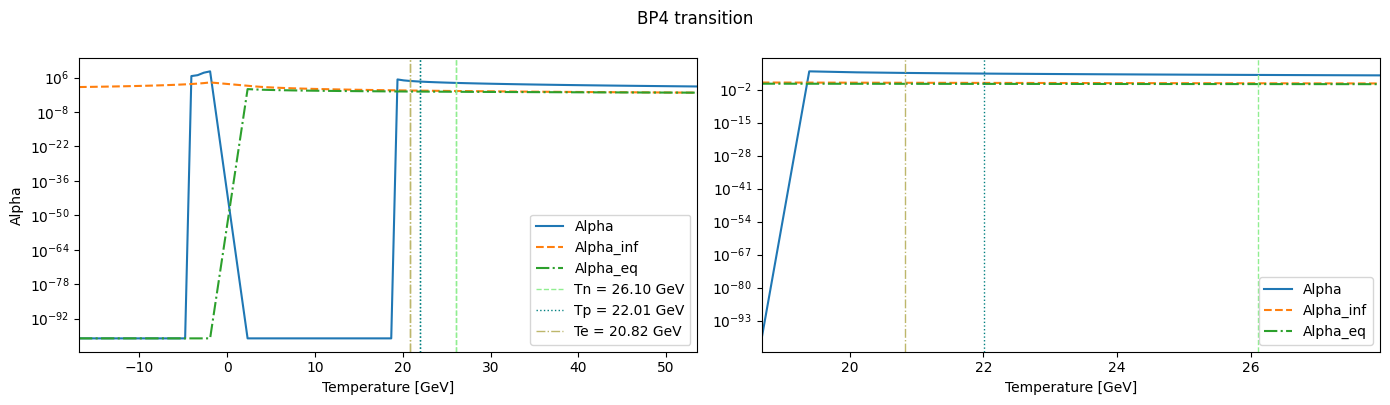

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from GWparams import cs2 # Import original cs2 if alpha_th_bar needs it
from GWparams import alpha_th_bar as original_alpha_th_bar # Import the original alpha_th_bar

# Explicitly disable LaTeX rendering to prevent ParseException
plt.rcParams['text.usetex'] = False

# Redefine alpha_th_bar locally to ensure proper array reshaping for dVdT calls
def alpha_th_bar_fixed(T, m, V_min_value, false_vev_dict, true_vev_dict, units='GeV'):
    # Ensure field values are 1D arrays
    false_vev_T_arr = np.atleast_1d(false_vev_dict[T]).reshape(-1, 1)
    true_vev_T_arr = np.atleast_1d(true_vev_dict[T]).reshape(-1, 1)

    delta_rho = - V_min_value[T] -  T * (
        m.dVdT(false_vev_T_arr, T, include_radiation=True, include_SM = False,  units = units) - \
        m.dVdT(true_vev_T_arr, T, include_radiation=True, include_SM = False,  units = units)
    )

    # Explicitly use the cs2_fixed function from the main namespace
    from __main__ import cs2_fixed
    c_s2_val = cs2_fixed(T, m, true_vev_dict, units=units)

    delta_p = V_min_value[T] / c_s2_val

    wf = - T * m.dVdT(false_vev_T_arr, T, include_radiation=True, include_SM = True,  units = units)
    w_th = - T * m.dVdT(true_vev_T_arr, T, include_radiation=True, include_SM = True,  units = units)

    return (delta_rho - delta_p) / (wf - w_th)


# Ensure alpha_T, alpha_inf_T, alpha_eq_T are properly defined
alpha_T = np.array([alpha_th_bar_fixed(T, dp, V_min_value, false_vev, true_vev, units) for T in Temps])
alpha_inf_T = np.array([c_alpha_inf(t, units)[0] for t in Temps]) # Corrected indexing
alpha_eq_T = np.array([c_alpha_eq(t, units)[0] for t in Temps]) # Corrected indexing

# Re-create mask to ensure it is consistent with the current Temps length
# This section ensures 'mask' is consistent with 'Temps' when used for indexing.
t_mil_min = np.nanmin([T_completion, T_perc, T_nuc])
t_mil_max = np.nanmax([T_completion, T_perc, T_nuc])

# Handle cases where min/max might be NaN if T_nuc, T_perc, T_completion are all NaN
if np.isnan(t_mil_min) or np.isnan(t_mil_max):
    # If no valid milestones (e.g., all T_nuc, T_perc, T_completion are NaN), use full range
    mask = np.ones_like(Temps, dtype=bool)
else:
    # Ensure indices are within bounds
    i0 = max(int(np.argmin(np.abs(Temps - t_mil_min))) - 3, 0)
    i1 = min(int(np.argmin(np.abs(Temps - t_mil_max))) + 3, len(Temps)-1)
    mask = np.zeros_like(Temps, dtype=bool)
    mask[i0:i1+1] = True

# Define a small positive floor for log plotting, and handle NaN/inf
plot_floor = 1e-100 # A very small positive number
def _log_plot_safe(arr):
    arr = np.asarray(arr, dtype=float)
    arr[np.isnan(arr)] = plot_floor # Replace NaN with floor
    arr[arr <= 0] = plot_floor # Replace non-positive with floor
    arr[np.isinf(arr)] = plot_floor # Replace inf with floor
    return arr

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].plot(Temps, _log_plot_safe(alpha_T), linestyle='-', label='Alpha')
axes[0].plot(Temps, _log_plot_safe(alpha_inf_T), linestyle='--', label='Alpha_inf')
axes[0].plot(Temps, _log_plot_safe(alpha_eq_T),  linestyle='-.', label='Alpha_eq')
axes[0].axvline(T_nuc, color='lightgreen', linestyle='--', linewidth=1, label=f'Tn = {T_nuc:.2f} {units}')
axes[0].axvline(T_perc, color='teal', linestyle=':', linewidth=1, label=f'Tp = {T_perc:.2f} {units}')
axes[0].axvline(T_completion, color='darkkhaki', linestyle='-.', linewidth=1, label=f'Te = {T_completion:.2f} {units}')
axes[0].set_xlabel(f"Temperature [{units}]")
axes[0].set_ylabel('Alpha')
axes[0].set_yscale('log')
axes[0].set_xlim(Temps[0], Temps[-1])
axes[0].legend()


axes[1].plot(Temps[mask], _log_plot_safe(alpha_T[mask]), label='Alpha', linestyle='-')
axes[1].plot(Temps[mask], _log_plot_safe(alpha_inf_T[mask]), label='Alpha_inf', linestyle='--')
axes[1].plot(Temps[mask], _log_plot_safe(alpha_eq_T[mask]), label='Alpha_eq', linestyle='-.')
axes[1].set_xlabel(f"Temperature [{units}]")
axes[1].set_xlim(Temps[mask][0], Temps[mask][-1])

y_data_masked = np.concatenate([_log_plot_safe(alpha_T[mask]), _log_plot_safe(alpha_inf_T[mask]), _log_plot_safe(alpha_eq_T[mask])])
y_data_masked_positive = y_data_masked[y_data_masked > plot_floor]

if len(y_data_masked_positive) > 1 and np.nanmax(y_data_masked_positive) > np.nanmin(y_data_masked_positive):
    axes[1].set_yscale('log')
else:
    axes[1].set_yscale('linear')
    axes[1].set_ylim(bottom=0)

axes[1].legend()

for ax in axes.flatten():
    ax.axvline(T_nuc, color='lightgreen', linestyle='--', linewidth=1, label=f'Tn = {T_nuc:.2f} {units}')
    ax.axvline(T_perc, color='teal', linestyle=':', linewidth=1, label=f'Tp = {T_perc:.2f} {units}')
    ax.axvline(T_completion, color='darkkhaki', linestyle='-.', linewidth=1, label=f'Te = {T_completion:.2f} {units}')

fig.suptitle(f'{description} transition', y=1.00)
plt.savefig(figure_dir + f"alpha_{description}.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [28]:
from temperatures import R_sepH
import numpy as np # Import numpy for np.interp

RH, R = R_sepH(Temps, Gamma, logP_f, H, ratio_V)
# Replace interpolation_narrow with np.interp for linear interpolation
RH_interp = np.interp(T_perc, Temps, RH)
H_star = np.interp(T_perc, Temps, H)
R_star = RH_interp / H_star

print(f"R* H* = {RH_interp:.2e}")

R* H* = 8.99e-02


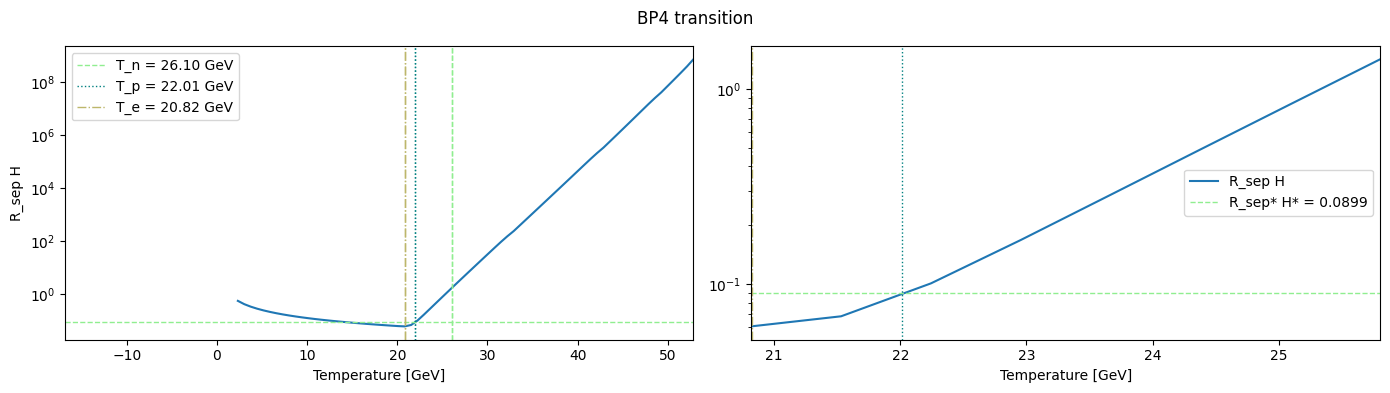

In [29]:
import matplotlib.pyplot as plt
import numpy as np


# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# First plot (full RH plot)
axes[0].plot(Temps, RH)
axes[0].set_ylabel('R_sep H')
axes[0].set_yscale('log')
axes[0].axhline(RH_interp, color='lightgreen', linestyle='--', linewidth=1)
axes[0].axvline(T_nuc, color='lightgreen', linestyle='--', linewidth=1, label=f'T_n = {T_nuc:.2f} {units}')
axes[0].axvline(T_perc, color='teal', linestyle=':', linewidth=1, label=f'T_p = {T_perc:.2f} {units}')
axes[0].axvline(T_completion, color='darkkhaki', linestyle='-.', linewidth=1, label=f'T_e = {T_completion:.2f} {units}')
axes[0].set_xlim(Temps[0], Temps[np.max(np.where(RH < np.inf)[0])])
axes[0].legend()

# Second plot (masked RH plot)
# Re-calculate mask based on milestones to ensure it covers a valid range
t_mil_min_plot = np.nanmin([T_completion, T_perc, T_nuc])
t_mil_max_plot = np.nanmax([T_completion, T_perc, T_nuc])

# Extend the range slightly for better visualization
padding = 0.05 * (t_mil_max_plot - t_mil_min_plot)
if np.isnan(padding):
    # Fallback if milestones are too close or NaN
    padding = 0.05 * (Temps[-1] - Temps[0]) # Use overall range

mask = (Temps >= t_mil_min_plot - padding) & (Temps <= t_mil_max_plot + padding)

# Ensure mask is not empty; if it is, fall back to a default reasonable range or full range
if not np.any(mask) and Temps.size > 0:
    # If the computed mask is still empty, try to ensure at least some points are covered
    center_T = T_perc if np.isfinite(T_perc) else np.mean(Temps)
    range_T = Temps[-1] - Temps[0]
    if range_T == 0: # Handle case of single point or all same temps
        mask = (Temps == center_T)
    else:
        mask = (Temps >= center_T - 0.1 * range_T) & (Temps <= center_T + 0.1 * range_T)
    if not np.any(mask):
        mask = np.ones_like(Temps, dtype=bool) # Fallback to full range if all else fails

# Plot only if the mask selects valid points
if np.any(mask):
    axes[1].plot(Temps[mask], RH[mask], label='R_sep H')
    axes[1].set_yscale('log')
    axes[1].axhline(RH_interp, color='lightgreen', linestyle='--', linewidth=1, label=f'R_sep* H* = {RH_interp:.4f}')
    axes[1].set_xlim(Temps[mask][0], Temps[mask][-1])
    axes[1].legend()
else:
    axes[1].set_title("No data in masked range")

# Add vertical lines to both plots for nucleation, percolation, and completion temperatures
for ax in axes.flatten():
    ax.axvline(T_nuc, color='lightgreen', linestyle='--', linewidth=1, label=f'T_n = {T_nuc:.2e} {units}')
    ax.axvline(T_perc, color='teal', linestyle=':', linewidth=1, label=f'T_p = {T_perc:.2e} {units}')
    ax.axvline(T_completion, color='darkkhaki', linestyle='-.', linewidth=1, label=f'T_e = {T_completion:.2e} {units}')
    ax.set_xlabel(f"Temperature [{units}]")

fig.suptitle(f'{description} transition', y=0.97)

# Save and show the plot
plt.savefig("RH_transition.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [30]:
T_perc

np.float64(22.011480222835466)

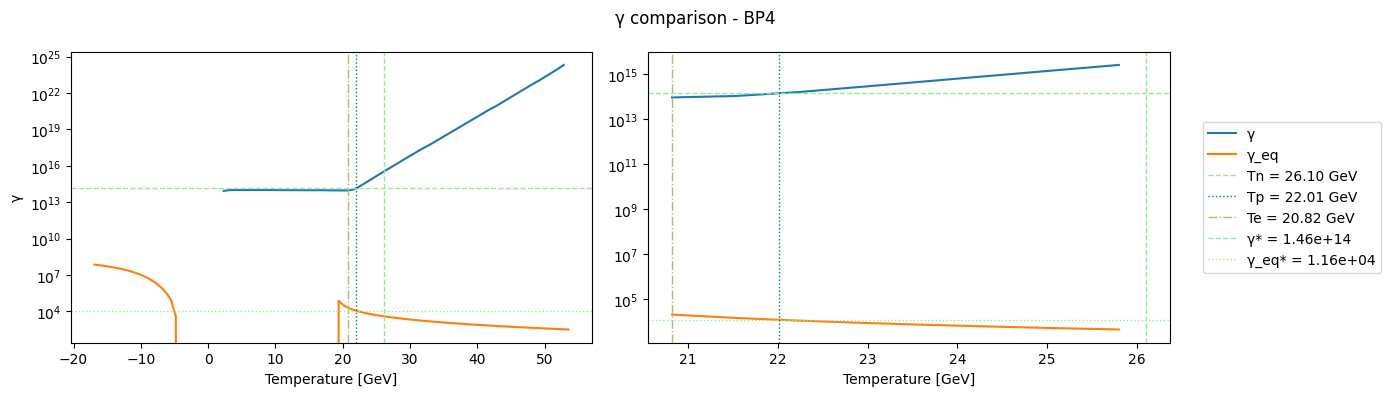

In [31]:
import numpy as np
from temperatures import R0
import matplotlib.pyplot as plt

# Explicitly disable LaTeX rendering
plt.rcParams['text.usetex'] = False

# Ensure numpy is imported for np.interp
r0 = np.array([R0(T, S3overT, V_exit) for T in Temps])

# Extract only the first element from the returned tuples to ensure consistent array shapes
alpha_T_1d = np.array([alpha_th_bar_fixed(T, dp, V_min_value, false_vev, true_vev, units) for T in Temps]).squeeze()
alpha_inf_T_1d = np.array([c_alpha_inf(t, units)[0] for t in Temps]).squeeze()
alpha_eq_T_1d = np.array([c_alpha_eq(t, units)[0] for t in Temps]).squeeze()

γ_eq_T = (alpha_T_1d - alpha_inf_T_1d) / alpha_eq_T_1d
γ = 2 * R / (3 * r0)

γ_star = 2 * R_star / (3 * R0(T_perc, S3overT, V_exit))
γ_eq_star = np.interp(T_perc, Temps, γ_eq_T)

# Create the plot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Plot γ and γ_eq with plain text labels
axes[0].plot(Temps, γ, label='γ')
axes[0].plot(Temps, γ_eq_T, label='γ_eq')
axes[0].set_yscale('log')
axes[0].set_xlabel(f'Temperature [{units}]')
axes[0].set_ylabel('γ')

# Plot for masked temperatures
axes[1].plot(Temps[mask], γ[mask], label='γ')
axes[1].plot(Temps[mask], γ_eq_T[mask], label='γ_eq')
axes[1].set_yscale('log')
axes[1].set_xlabel(f'Temperature [{units}]')
axes[1].legend()

# Add vertical and horizontal lines for critical temperatures
for ax in axes.flatten():
    ax.axvline(T_nuc, color='lightgreen', linestyle='--', linewidth=1, label=f'Tn = {T_nuc:.2f} {units}')
    ax.axvline(T_perc, color='teal', linestyle=':', linewidth=1, label=f'Tp = {T_perc:.2f} {units}')
    ax.axvline(T_completion, color='darkkhaki', linestyle='-.', linewidth=1, label=f'Te = {T_completion:.2f} {units}')
    ax.axhline(γ_star, color='lightgreen', linestyle='--', linewidth=1, label=f'γ* = {γ_star:.2e}')
    ax.axhline(γ_eq_star, color='lightgreen', linestyle=':', linewidth=1, label=f'γ_eq* = {γ_eq_star:.2e}')

handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1.05, 0.5))

# Title for the figure
fig.suptitle(f'γ comparison - {description}')
plt.tight_layout()
plt.show()

In [33]:
from GWparams import beta
import temperatures as temp # Import the temperatures module to access compute_logP_f

logP_f, Temps, ratio_V, Gamma, H = temp.compute_logP_f(dp, V_min_value, S3overT, v_w = 1, units = units, cum_method= 'None')

beta_Hn, gamma_Hn, times, Gamma_t, Temps_t, H_t = beta(Temps, ratio_V, Gamma, H, T_nuc, T_perc, verbose = True)

# delta = (T_nuc - T_perc) / 2
# beta_Hn, gamma_Hn, times, Gamma_t, Temps_t, H_t = beta(Temps, ratio_V, Gamma, H, T_perc + delta, T_perc - delta, verbose = True)

print("beta =", beta_Hn)
print("gamma =", gamma_Hn)

beta = 54.186590959176094
gamma = 5.083544045212292


/tmp/ipython-input-3099741673.py:66: RuntimeWarning: invalid value encountered in multiply
  Gamma = Temps**4 * (S3_T / (2*np.pi))**(3/2) * np.exp(-S3_T)


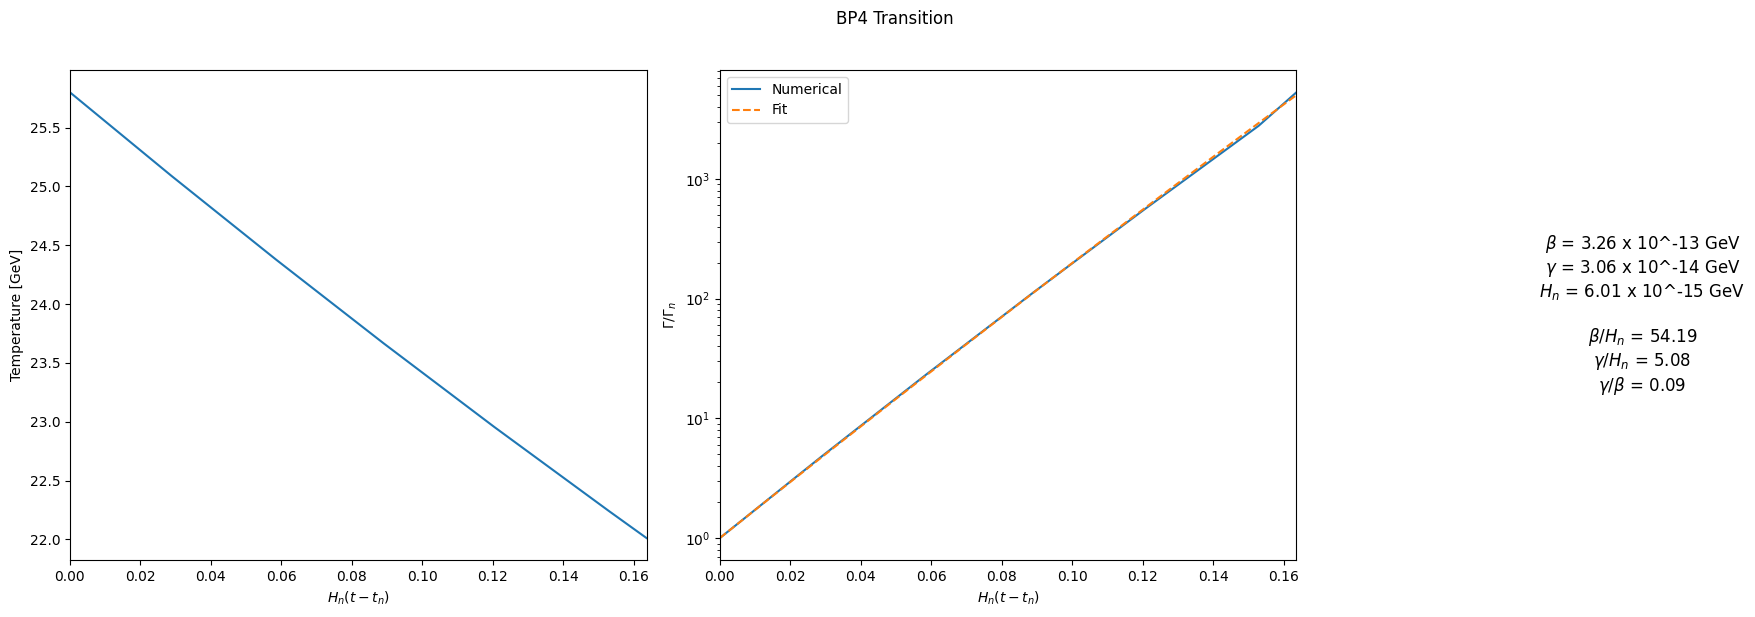

Percolation at 1.64e-01


In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming values for times, Temps_t, Gamma_t, beta_Hn, gamma_Hn, and units are already defined

Gamma_n = Gamma_t[0]
H_n = H_t[0]

def scientific_notation(number):
    """ Return a string formatted in scientific notation with double caret for LaTeX. """
    exponent = int(np.floor(np.log10(abs(number))))
    coefficient = number / 10**exponent
    return f"{coefficient:.2f} x 10^{exponent}"


# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plotting the temperature evolution
axes[0].plot(times, Temps_t)
axes[0].set_xlabel(r"$H_n (t - t_n)$")
axes[0].set_ylabel(f"Temperature [{units}]")
axes[0].set_xlim(times[0], times[-1])

# Prepare the text box to display parameter values
box_text = (
    f"$\\beta$ = {scientific_notation(beta_Hn * H_n)} {units}\n"
    f"$\\gamma$ = {scientific_notation(gamma_Hn * H_n)} {units}\n"
    f"$H_n$ = {scientific_notation(H_n)} {units}\n\n"
    f"$\\beta / H_n$ = {beta_Hn:.2f}\n"
    f"$\\gamma / H_n$ = {gamma_Hn:.2f}\n"
    f"$\\gamma / \\beta$ = {gamma_Hn / beta_Hn:.2f}"
)

# Plotting Gamma values and the fit
axes[1].plot(times, Gamma_t / Gamma_t[0], label="Numerical")
tfit = np.linspace(times[0], times[-1], 100, endpoint=True)
axes[1].plot(tfit, np.exp(beta_Hn * tfit - (gamma_Hn * tfit) ** 2 / 2), label="Fit", linestyle='--')
axes[1].set_xlabel(r"$H_n (t - t_n)$")
axes[1].set_ylabel(r"$\Gamma / \Gamma_n$")
axes[1].set_yscale('log')
axes[1].set_xlim(times[0], times[-1])

# Adding the parameter box on the plot using $$ for LaTeX-friendly format
axes[1].text(1.6, 0.5, box_text,       # coordinates (0-1 for normalized)
             fontsize='large',
             transform=axes[1].transAxes,  # use normalized coordinates
             horizontalalignment='center', # center text horizontally
             verticalalignment='center')   # center text vertically

axes[1].legend()

# Title and layout
plt.suptitle(f'{description} Transition', y=1.02)
plt.tight_layout()

# Saving the figure to a file
plt.savefig(figure_dir + f"nucleation_{description}.pdf", dpi=300, bbox_inches='tight')
plt.show()

print(f"Percolation at {times[-1]:.2e}")


In [35]:
from google.colab import files

uploaded = files.upload()

Saving NG15.pkl to NG15.pkl


In [36]:
import matplotlib.pyplot as plt

plt.ion()          # re-enable interactive plotting
plt.close("all")   # clean broken figures


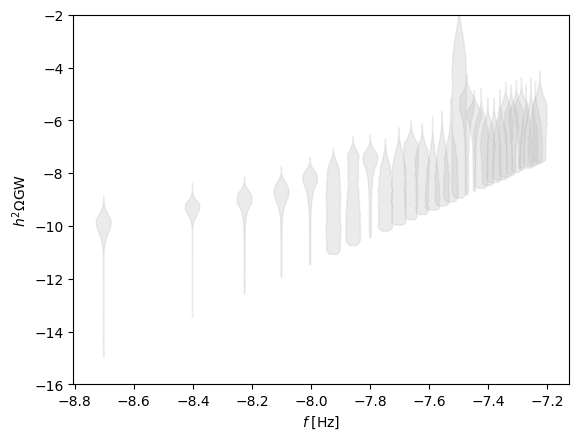

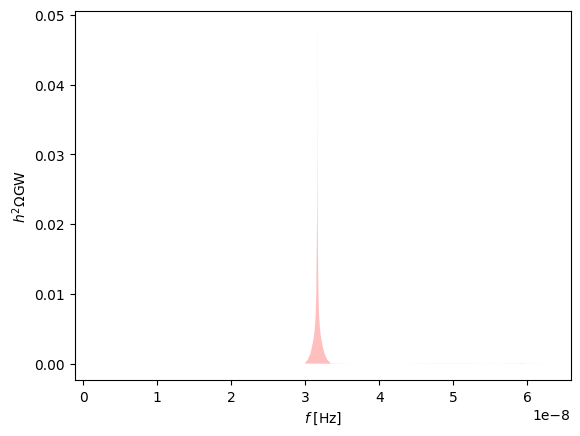

In [37]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
pkl_path = "NG15.pkl"

with open(pkl_path, "rb") as f:
    fig, ax = pickle.load(f)

fig_linear, ax_linear = plt.subplots(figsize=fig.get_size_inches())

for collection in ax.collections:
    if hasattr(collection, "get_paths") and len(collection.get_paths()) > 0:
        path = collection.get_paths()[0]
        vertices = path.vertices

        if len(vertices) > 0:
            x_log = vertices[:, 0]
            y_log = vertices[:, 1]

            x_linear = 10**x_log
            y_linear = 10**y_log

            ax_linear.fill(
                x_linear,
                y_linear,
                facecolor="red",        # <-- force red
                edgecolor="none",       # cleaner for papers
                alpha=0.25,             # good transparency
            )

ax_linear.set_xscale("linear")
ax_linear.set_yscale("linear")
ax_linear.set_xlabel(ax.get_xlabel())
ax_linear.set_ylabel(ax.get_ylabel())
ax_linear.set_title(ax.get_title())

plt.show()


In [38]:
x=(alpha+1)**(1/4)

In [39]:
T_reh=x*T_perc

Is physical? True
lambda = 0.006
g = 0.749938
vev = 3 GeV
m_phi = 0.3286335345030997 GeV
m_Z = 2.2498139999999998 GeV
T_crit = 35.93999999999909 GeV
T_nuc = 26.103739583101724 GeV
T_perc = 22.011480222835466 GeV
T_completion = 20.82475878238344 GeV
T_min = 0.7187999999999818 GeV
T_reh = 69.58896812610705 GeV
Minimal value of P_f = 0.0
alpha = 98.89979375244887, alpha_inf = 4.944609547671546, alpha_eq = 2.0250739432725924
gamma_* = 145938877198553.56, gamma_eq = 46.39592767311122
Is runaway? True
RH = 0.08988199881883234


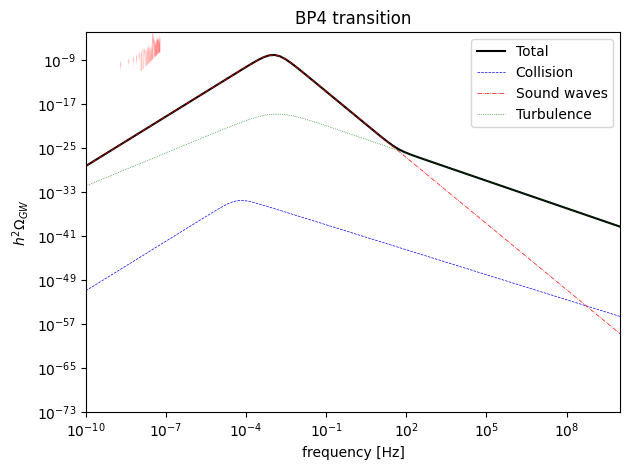

In [40]:
import pickle
from GWparams import GW_SuperCooled
import contextlib
import os # Import the os module

def print_params():
    print(f"Is physical? {is_physical}")
    print(f"lambda = {lambda_}")
    print(f"g = {g}")
    print(f"vev = {vev} {units}")
    print(f"m_phi = {np.sqrt(2*lambda_)*vev} {units}")
    print(f"m_Z = {g*vev} {units}")
    print(f"T_crit = {T_max} {units}")
    print(f"T_nuc = {T_nuc} {units}")
    print(f"T_perc = {T_perc} {units}")
    print(f"T_completion = {T_completion} {units}")
    print(f"T_min = {T_min} {units}")
    print(f"T_reh = {T_reh} {units}")
    print(f"Minimal value of P_f = {np.nanmin(np.exp(logP_f))}")
    print(f"alpha = {alpha}, alpha_inf = {alpha_inf}, alpha_eq = {alpha_eq}")
    print(f"gamma_* = {γ_star}, gamma_eq = {gamma_eq}")
    print(f"Is runaway? {alpha > alpha_inf}")
    print(f"RH = {R_star * H_star}")
    #print(f"beta/H_n = {beta_H0}, gamma/H_n = {gamma_H0}, gamma/beta = {gamma_H0/beta_H0}")

# Ensure the figure directory exists (already done in other cells, but good practice)
os.makedirs(figure_dir, exist_ok=True)

# Save the relevant reults to a file
with open(os.path.join(figure_dir, f'{description}.txt'), 'w') as f:
    with contextlib.redirect_stdout(f):
        print_params()

log_freq_min = -10
log_freq_max = 10

if T_perc is not None:
    inst = GW_SuperCooled(T_perc, alpha, alpha_inf, alpha_eq, R_star, γ_star, H_star, c_s = np.sqrt(c_s2), units = units)
    print_params()

    x = np.linspace(log_freq_min, log_freq_max, 100)
    x = 10**x
    ax_linear.plot(x, inst.Omegah2(x), label = "Total", color='black')
    ax_linear.plot(x, inst.Omegah2coll(x), label = "Collision", linewidth=0.5, color='blue', linestyle='--')
    ax_linear.plot(x, inst.Omegah2sw(x), label = "Sound waves", linewidth=0.5, color='red', linestyle='-.')
    ax_linear.plot(x, inst.Omegah2turb(x), label = "Turbulence", linewidth=0.5, color='green', linestyle=':')
    ax_linear.set_xlim(x[0], x[-1])
    ax_linear.set_ylim(1e-73, 1e-4)
    ax_linear.set_xscale('log')
    ax_linear.set_yscale('log')
    ax_linear.set_xlabel('frequency [Hz]')
    ax_linear.set_ylabel('$h^2 \Omega_{GW}$')
    #plt.title(f'GW spectrum - {description}')
    ax_linear.legend()
    ax_linear.set_title(f'{description} transition', y=1)
    fig_linear.savefig(figure_dir + f"GW_{description}.pdf", dpi=300, bbox_inches='tight')
    fig_linear.tight_layout()

# Save the for spectrum future plotting
if is_physical:
    with open(os.path.join(figure_dir, f'GW_{description}.pkl'), 'wb') as f: # Use os.path.join here as well
        pickle.dump(inst, f)

fig_linear